In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np 
import h5py
import os
import re

In [2]:
catdir='CatSim_CosmoDC2_Data'
solution_id = 'solution_1'
datfile='extincted_fit_{}_9556.hdf5'.format(solution_id)
catfile=os.path.join(catdir, datfile)
hf = h5py.File(catfile, 'r')
print(list(hf.keys()))
print(hf['galaxy_id'].value[0:5])

['CatSim_fit_obs_g', 'CatSim_fit_obs_i', 'CatSim_fit_obs_r', 'CatSim_fit_obs_u', 'CatSim_fit_obs_y', 'CatSim_fit_obs_z', 'CatSim_fit_rest_g', 'CatSim_fit_rest_i', 'CatSim_fit_rest_r', 'CatSim_fit_rest_u', 'CatSim_fit_rest_y', 'CatSim_fit_rest_z', 'bulge_dist', 'bulge_sed', 'cosmoDC2_obs_g', 'cosmoDC2_obs_i', 'cosmoDC2_obs_r', 'cosmoDC2_obs_u', 'cosmoDC2_obs_y', 'cosmoDC2_obs_z', 'cosmoDC2_rest_g', 'cosmoDC2_rest_i', 'cosmoDC2_rest_r', 'cosmoDC2_rest_u', 'cosmoDC2_rest_y', 'cosmoDC2_rest_z', 'disk_dist', 'disk_sed', 'galaxy_id', 'redshift_true', 'stellar_mass', 'stellar_mass_bulge', 'stellar_mass_disk']
[4000000001 4000000002 4000000007 4000000040 4000000051]


In [3]:
#check that cosmoDC2 quantities match with original catalog
import sys
sys.path.insert(0, '/global/u1/k/kovacs/gcr-catalogs_master')
import GCRCatalogs
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.0_9556')

In [4]:
keys = gc.list_all_quantities()
lsst_keys = [k for k in keys if 'lsst' in k and 'Mag' in k and 'no_host' not in k]
#SED_keys = [k for k in keys if 'sed' in k and 'bulge' not in k and 'disk' not in k]
#print(sorted(SED_keys))
#all_keys = gc.list_all_native_quantities()
#sfr_keys = [k for k in all_keys if 'StarFormationRate' in k or 'sfr' in k or 'SFR' in k]
#print(sfr_keys)

In [5]:
quantities = ['galaxy_id', 'redshift_true'] + lsst_keys
cosmodc2_ref = gc.get_quantities(quantities)
print(list(cosmodc2_ref.keys()))

['Mag_true_i_lsst_z0', 'Mag_true_u_lsst_z0', 'galaxy_id', 'redshift_true', 'Mag_true_r_lsst_z0', 'Mag_true_z_lsst_z0', 'Mag_true_Y_lsst_z0', 'Mag_true_g_lsst_z0', 'Mag_true_y_lsst_z0']


In [6]:
logmstar = np.log10(hf['stellar_mass'].value)
print(len(logmstar))
logm = 10
mask = (logmstar >= 10) & (logmstar < 11)
print(np.count_nonzero(mask))
sort_idx = cosmodc2_ref['galaxy_id'].argsort()
matches = sort_idx[np.searchsorted(cosmodc2_ref['galaxy_id'], hf['galaxy_id'].value[mask], sorter = sort_idx)]
print(len(matches), cosmodc2_ref['galaxy_id'][matches[0:5]], hf['galaxy_id'].value[mask][0:5] )

17104963
123047
123047 [4000000001 4000000137 4000000868 4000000914 4000001691] [4000000001 4000000137 4000000868 4000000914 4000001691]


In [7]:
def get_colors(bands, color_dict, key_template):
    for b1, b2 in zip(bands[0:-1], bands[1:]):
        k1 = key_template.format(b1)
        k2 = key_template.format(b2)
        color_dict['('+b1+'-'+b2+')'] = color_dict[k1] - color_dict[k2]

    return color_dict

In [8]:
def get_dict(hf, logmass, logmstar, key_template, frames, bands):
    datadict={}
    for logm in logmass:
        mask = (logmstar >= logm) & (logmstar < logm+1)
        #print('mass-mask', logm, np.count_nonzero(mask))
        key = '{}'.format(str(logm))
        datadict[key] = {}
        datadict[key]['galaxy_id'] = hf['galaxy_id'].value[mask]
        datadict[key]['redshift'] = hf['redshift_true'].value[mask]
        #print(len(datadict[str(logm)]['galaxy_id']), datadict[str(logm)]['galaxy_id'][0:5])
        for f in frames:
            datadict[key][f] = {}
            for band in bands:
                hf_key = key_template.format(f, band)
                datadict[key][f][band] = hf[hf_key].value[mask]
            
    #print(list(datadict.keys()))
    return datadict

In [9]:
logmstar = np.log10(hf['stellar_mass'].value)
print(len(logmstar), np.min(logmstar), np.max(logmstar))
logmass = [6, 7, 8, 9, 10, 11]
bands = ['u', 'g', 'r', 'i', 'z', 'y']
frames =['rest', 'obs']
catsim_template = 'CatSim_fit_{}_{}'
cosmodc2_template = 'cosmoDC2_{}_{}'
#cosmodc2_Mtemplate_nox = 'Mag_true_{}_lsst_z0_no_host_extinction'
#cosmodc2_mtemplate_nox = 'mag_true_{}_lsst_no_host_extinction'
#cosmodc2_Mtemplate = 'Mag_true_{}_lsst_z0'
#cosmodc2_mtemplate = 'mag_true_{}_lsst'

catsim = get_dict(hf, logmass, logmstar, catsim_template, frames, bands)
cosmodc2 = get_dict(hf, logmass, logmstar, cosmodc2_template, frames, bands)
    
#print(list(catsim.keys()), list(cosmodc2.keys()))
#cosmodc2_ref = get_colors(bands, cosmodc2_ref, cosmodc2_Mtemplate)

for logm in logmass:
    key = '{}'.format(str(logm))
    for f in frames:
        key = '{}'.format(str(logm))
        catsim[key][f] = get_colors(bands, catsim[key][f], '{}')
        cosmodc2[key][f] = get_colors(bands, cosmodc2[key][f], '{}')

logm =logmass[4]
print(logm, list(catsim[str(logm)]['rest'].keys()), list(cosmodc2[str(logm)]['obs'].keys()))
#print(catsim[str(logm)]['galaxy_id'][0:5], cosmodc2[str(logm)]['galaxy_id'][0:5])

17104963 3.7097 12.2351
10 ['u', 'g', 'r', 'i', 'z', 'y', '(u-g)', '(g-r)', '(r-i)', '(i-z)', '(z-y)'] ['u', 'g', 'r', 'i', 'z', 'y', '(u-g)', '(g-r)', '(r-i)', '(i-z)', '(z-y)']


In [10]:
def plot_qty_dist(cosmodc2, catsim, maskz, qtys, Nbins, 
                  cd2_color, cs_color, alpha, fig_id, title):
    fig, ax_all = plt.subplots(2, 3, figsize=(11, 8), sharey='row')
    for q, ax in zip_longest(qtys, ax_all.flat):
        if q is None:
            ax.set_visible(False)
        else:
            cosmodc2_q = cosmodc2[q][maskz]
            catsim_q = catsim[q][maskz]
            bin_min = min(np.min(catsim_q), np.min(cosmodc2_q))
            bin_max = max(np.max(catsim_q), np.max(cosmodc2_q))
            bins = np.linspace(bin_min, bin_max, Nbins+1)
            #print('{}:, #cosmoDC2={}, #catsim={}'.format(q, len(cosmodc2_q), len(catsim_q)))
            ax.hist(cosmodc2_q, bins=bins, color=cd2_color, label='CosmoDC2', alpha=alpha)
            ax.hist(catsim_q, bins=bins, color=cs_color, label='CatSim', alpha=alpha)
            ax.legend(loc='best')
            ax.set_xlabel('{}'.format(q))
            fig.suptitle(title, size=16)
            fig.tight_layout()
            fig.subplots_adjust(top=0.94)
            
    figname = '{}.png'.format(fig_id)
    print('Saving {}'.format(figname))
    fig.savefig(figname, bbox_inches='tight') 

In [11]:
def plot_qty_diff(cosmodc2, catsim, maskz, qtys, frames, Nbins,
                  frame_colors, alpha, fig_id, title):
    fig, ax_all = plt.subplots(2, 3, figsize=(11, 8), sharey='row')
    for q, ax in zip_longest(qtys, ax_all.flat):
        if q is None:
            ax.set_visible(False)
        else:
            q_diff = {}
            for f in frames:
                q_diff[f] = cosmodc2[f][q][maskz] - catsim[f][q][maskz]
                q_diff['min'] = min(np.min(q_diff[f]), q_diff.get('min', np.inf))
                q_diff['max'] = max(np.max(q_diff[f]), q_diff.get('max', -np.inf))
                #print(q_diff['min'], q_diff['max'])
                
            bins = np.linspace(q_diff['min'], q_diff['max'], Nbins+1)
            for f, col in zip(frames, frame_colors):
                label = '$\Delta \\rm{{ {}_ {{ {} }} }}$'.format(q, f)
                ax.hist(q_diff[f], bins=bins, color=col, label=label, alpha=alpha)

            ax.set_xlabel('$\\rm {}_{} - \\rm {}_{}$'.format(q,'{\\rm{CosmoDC2}}', q, '{\\rm{CatSim}}'))
            ax.legend(loc='best')
            fig.suptitle(title, size=16)
            fig.tight_layout()
            fig.subplots_adjust(top=0.94)
            
    figname = '{}.png'.format(fig_id)
    print('Saving {}'.format(figname))
    fig.savefig(figname, bbox_inches='tight') 

In [17]:
def plot_qxqy_2dmap(cosmodc2, catsim, maskz, qx, qy, Nxbins, Nybins, cs_levels, cd2_levels,
                  cd2_color, cs_color, cd2_map, cs_map, alpha, fig_id, title):
    fig, ax_all = plt.subplots(2, 4, figsize=(15, 8), sharex='col')
    for n, (cx, cy) in enumerate(zip(qx, qy)):
        ax = ax_all.flat[n] #top row
        ax4 = ax_all.flat[n+4] #bottom row
        #cosmodc2
        CD2, xedges, yedges = np.histogram2d(cosmodc2[cx][maskz], 
                                    cosmodc2[cy][maskz],
                                    bins=(Nxbins, Nybins), normed=True)
        #print(xedges, yedges)
        x_cen, y_cen = np.meshgrid(xedges[:-1], yedges[:-1])
        x_cen += (0.5*(xedges[1]-xedges[0]))  #find bin centers
        y_cen += (0.5*(yedges[1]-yedges[0]))
        x_wid = xedges[1] - xedges[0]
        y_wid = yedges[1] - yedges[0]
        max_cd2 = np.max(CD2)
        #catsim
        CS, xedges, yedges = np.histogram2d(catsim[cx][maskz], 
                                            catsim[cy][maskz],
                                            bins=(xedges, yedges), normed=True)
        max_cs = np.max(CS)
        #plot CatSim contours with cosmoDC2 density, CosmoDC2 contours with Catsim density
        #catsim density
        CSmasked = np.ma.masked_where(CS.T==0.0, CS.T)
        hs = ax4.pcolormesh(xedges, yedges, CSmasked, cmap=cs_map)#, alpha=alpha2d)          
        cbs = plt.colorbar(hs, ax=ax4)
        rlabelcs = '$\\rm{{P_{{CatSim}}({},\ {})}}$'.format(cx, cy)
        cbs.set_label(rlabelcs)
            
        #cosmoDC2 2-d probability density
        CD2masked = np.ma.masked_where(CD2.T==0.0, CD2.T)
        hd2 = ax.pcolormesh(xedges, yedges, CD2masked, cmap=cd2_map)#, alpha=alpha2d)
        cb2 = plt.colorbar(hd2, ax=ax)
        rlabeld2 = '$\\rm{{P_{{CosmoDC2}}({},\ {})}}$'.format(cx, cy)
        cb2.set_label(rlabeld2)
            
        #catsim contours
        cslevel = [l*max_cs for l in cs_levels]
        #print('cs', cslevel)
        cnt2= ax.contour(x_cen, y_cen, CS.T, colors=cs_color, 
                         levels=cslevel, linewidth=linewidths, alpha=alphactr)
        ax.clabel(cnt2, inline=1, fontsize=8)
        cnt2.collections[0].set_label('CatSim')
            
        #plot cosmoDC2 contours
        cd2level = [l*max_cd2 for l in cd2_levels]
        #print('cd2', cd2level)
        cnt1 = ax4.contour(x_cen, y_cen, CD2.T, colors=cd2_color, 
                           levels=cd2level, linewidth=linewidths, alpha=alphactr)
        ax4.clabel(cnt1, inline=1, fontsize=8)
        cnt1.collections[0].set_label('CosmoDC2')
            
        for axx in [ax, ax4]:
            axx.set_xlim(np.min(xedges) - margin*x_wid, np.max(xedges) + margin*x_wid)
            axx.set_ylim(np.min(yedges) - margin*x_wid, np.max(yedges) + margin*y_wid)
            for tick in axx.yaxis.get_major_ticks():
                tick.label.set_fontsize('small') 
                tick.label.set_rotation('vertical')
            axx.legend(loc='lower right')
            axx.set_xlabel('{}'.format(cx))
            axx.set_ylabel('{}'.format(cy))
                
        fig.suptitle('{}'.format(title), size=16)
        fig.tight_layout()
        fig.subplots_adjust(hspace=0)
        fig.subplots_adjust(top=0.94)
            
    figname = '{}.png'.format(fig_id)
    print('Saving {}'.format(figname))
    fig.savefig(figname, bbox_inches='tight') 

Number of entries 13992
Saving solution_1/mag_rest_logM_9_z_0.0_0.5_solution_1.png
Saving solution_1/color_rest_logM_9_z_0.0_0.5_solution_1.png
Saving solution_1/color_color_rest_logM_9_z_0.0_0.5_solution_1.png
Saving solution_1/mag_obs_logM_9_z_0.0_0.5_solution_1.png
Saving solution_1/color_obs_logM_9_z_0.0_0.5_solution_1.png
Saving solution_1/color_color_obs_logM_9_z_0.0_0.5_solution_1.png
Saving solution_1/delta_mag_logM_9_z_0.0_0.5_solution_1.png
Saving solution_1/delta_color_logM_9_z_0.0_0.5_solution_1.png
Number of entries 60117
Saving solution_1/mag_rest_logM_9_z_0.5_1.0_solution_1.png
Saving solution_1/color_rest_logM_9_z_0.5_1.0_solution_1.png
Saving solution_1/color_color_rest_logM_9_z_0.5_1.0_solution_1.png
Saving solution_1/mag_obs_logM_9_z_0.5_1.0_solution_1.png
Saving solution_1/color_obs_logM_9_z_0.5_1.0_solution_1.png
Saving solution_1/color_color_obs_logM_9_z_0.5_1.0_solution_1.png
Saving solution_1/delta_mag_logM_9_z_0.5_1.0_solution_1.png
Saving solution_1/delta_colo

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving solution_1/color_obs_logM_9_z_1.0_1.5_solution_1.png
Saving solution_1/color_color_obs_logM_9_z_1.0_1.5_solution_1.png
Saving solution_1/delta_mag_logM_9_z_1.0_1.5_solution_1.png
Saving solution_1/delta_color_logM_9_z_1.0_1.5_solution_1.png
Number of entries 8784
Saving solution_1/mag_rest_logM_10_z_0.0_0.5_solution_1.png
Saving solution_1/color_rest_logM_10_z_0.0_0.5_solution_1.png
Saving solution_1/color_color_rest_logM_10_z_0.0_0.5_solution_1.png
Saving solution_1/mag_obs_logM_10_z_0.0_0.5_solution_1.png
Saving solution_1/color_obs_logM_10_z_0.0_0.5_solution_1.png
Saving solution_1/color_color_obs_logM_10_z_0.0_0.5_solution_1.png
Saving solution_1/delta_mag_logM_10_z_0.0_0.5_solution_1.png
Saving solution_1/delta_color_logM_10_z_0.0_0.5_solution_1.png
Number of entries 30788
Saving solution_1/mag_rest_logM_10_z_0.5_1.0_solution_1.png
Saving solution_1/color_rest_logM_10_z_0.5_1.0_solution_1.png
Saving solution_1/color_color_rest_logM_10_z_0.5_1.0_solution_1.png
Saving solutio

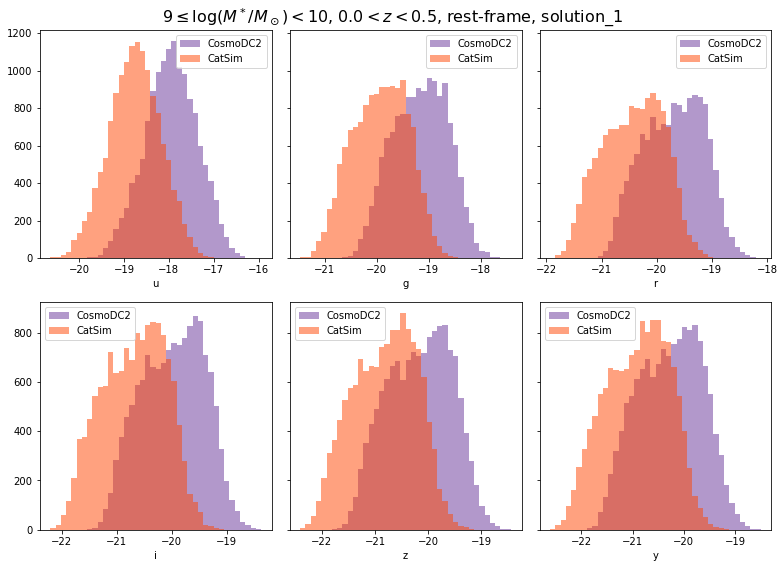

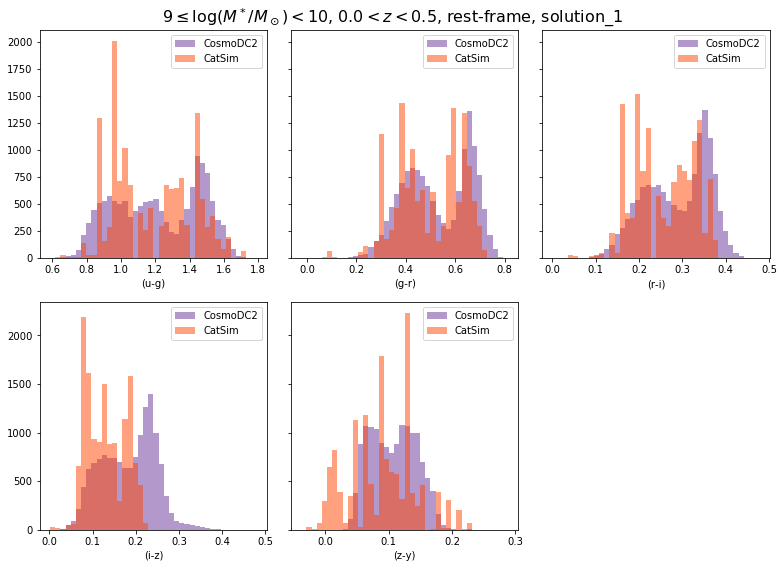

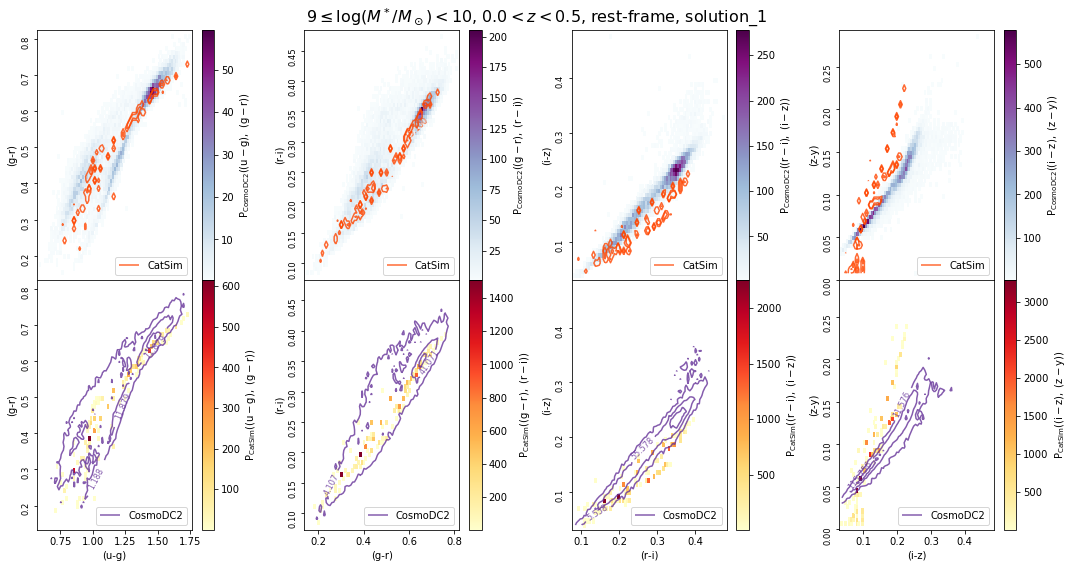

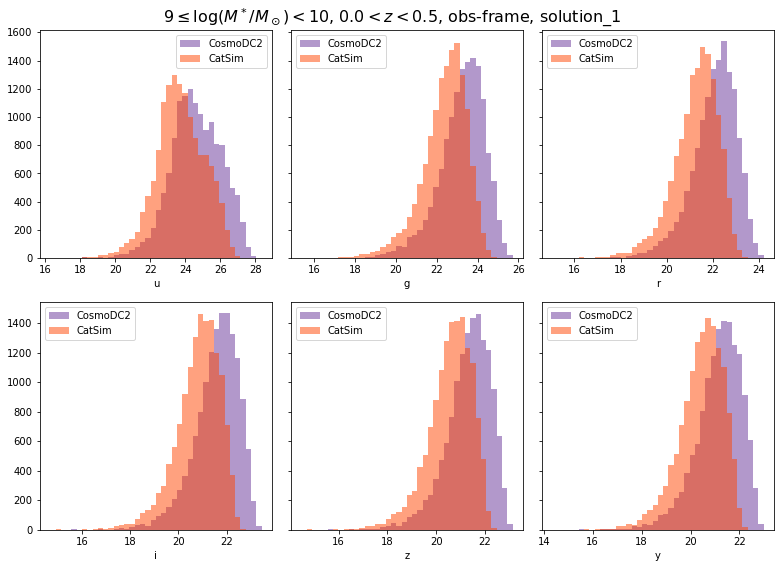

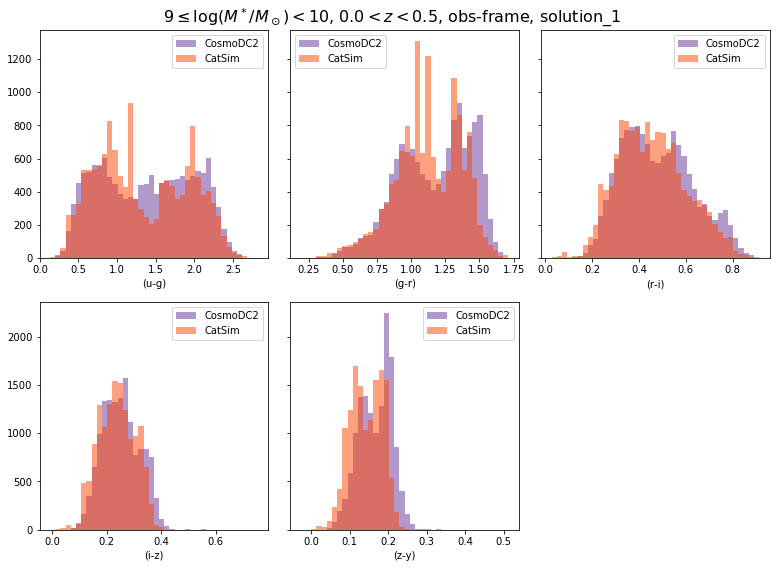

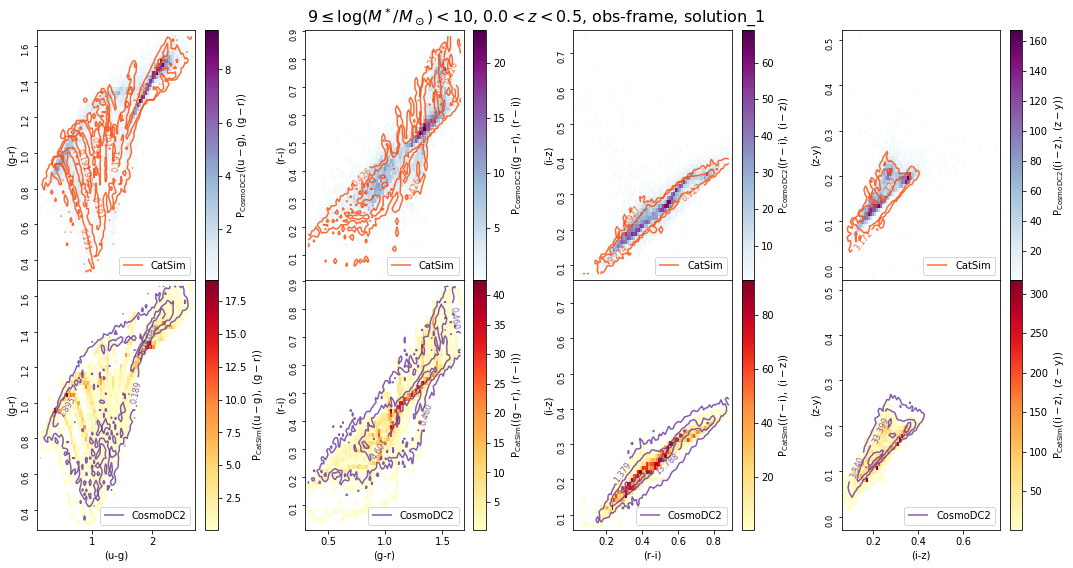

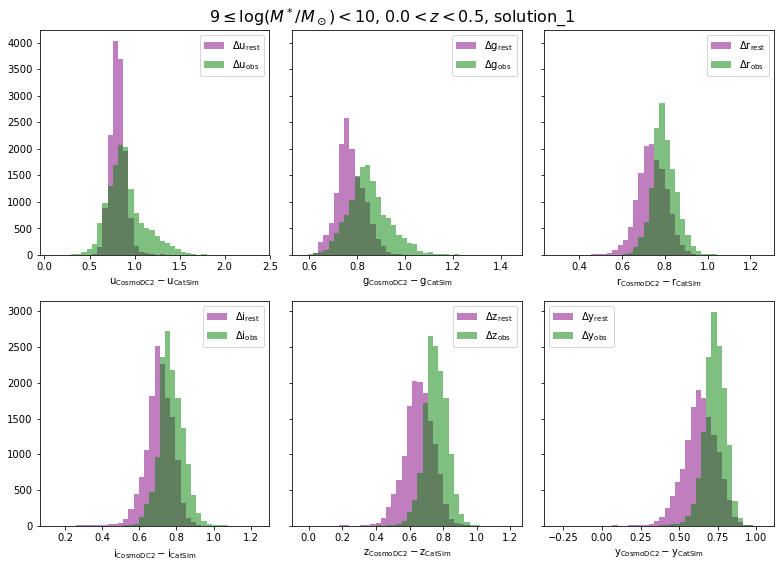

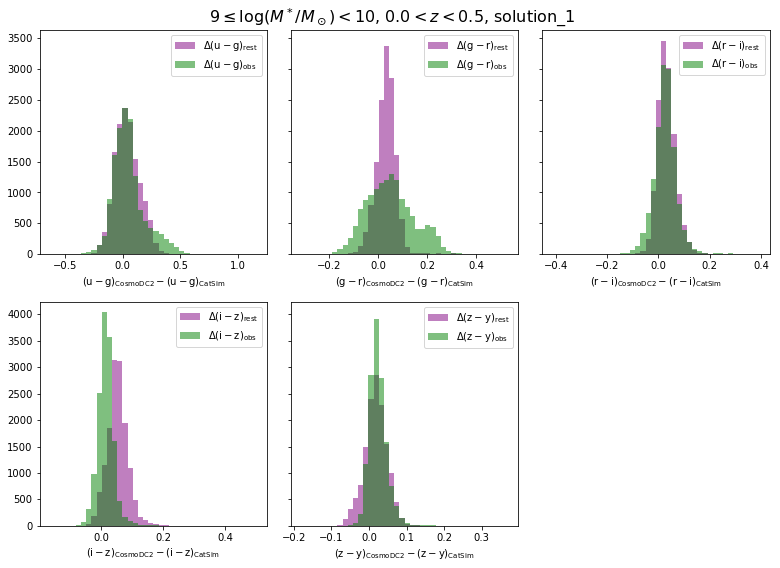

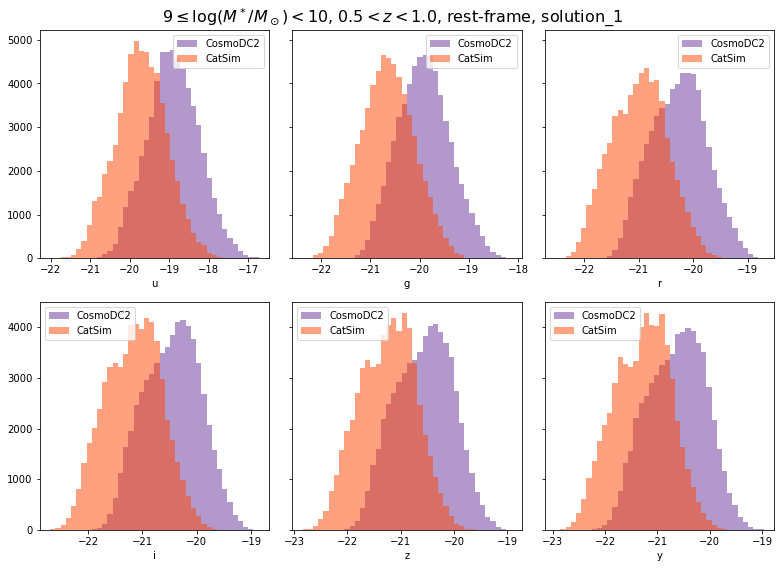

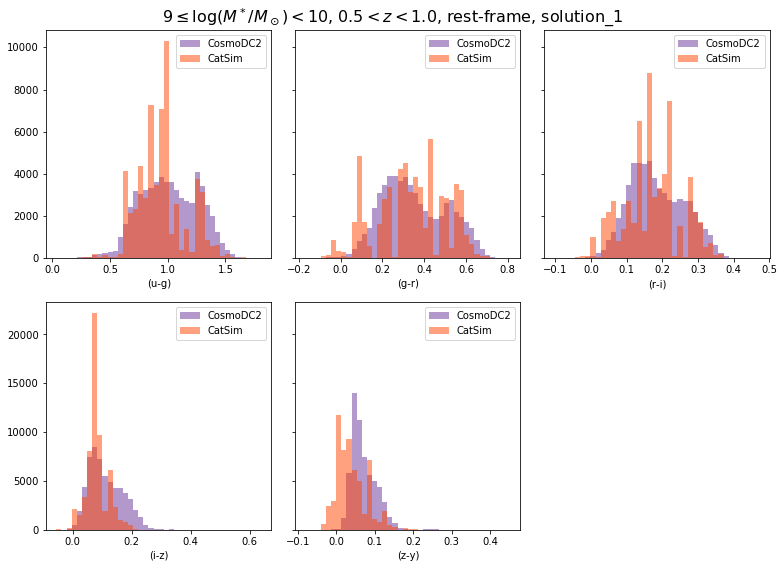

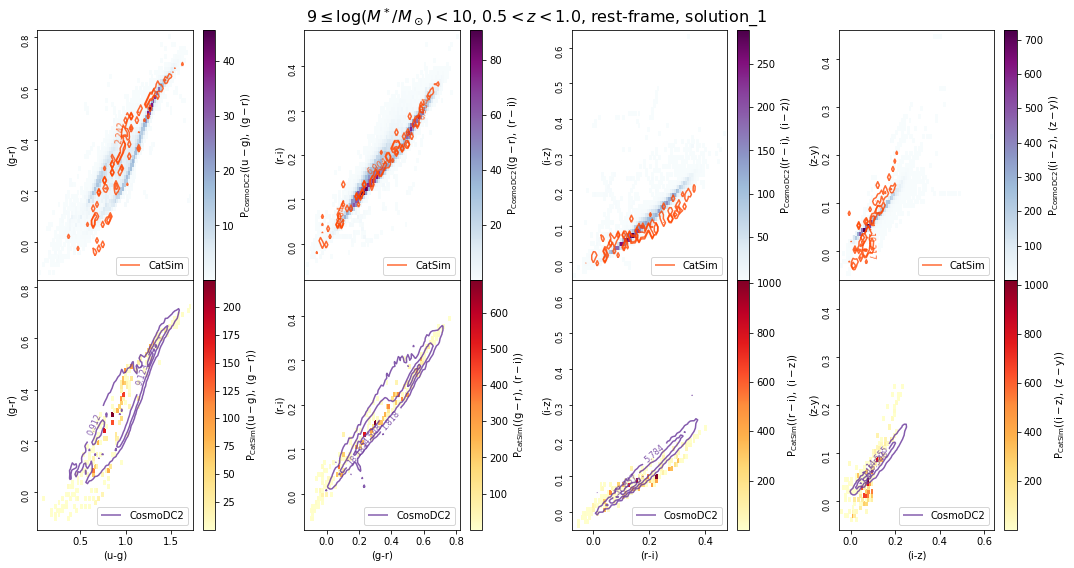

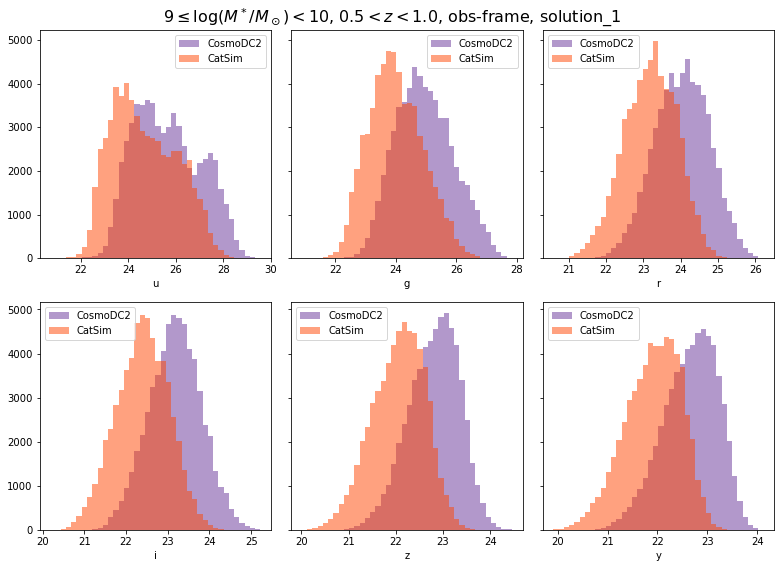

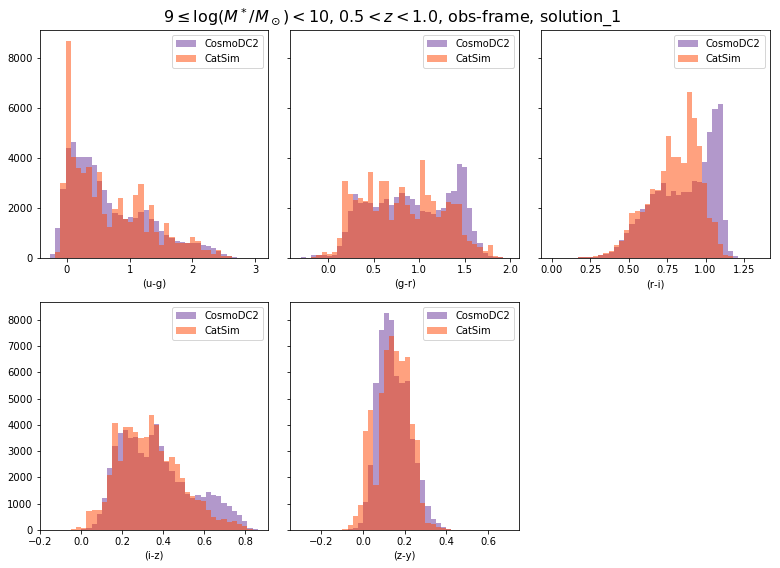

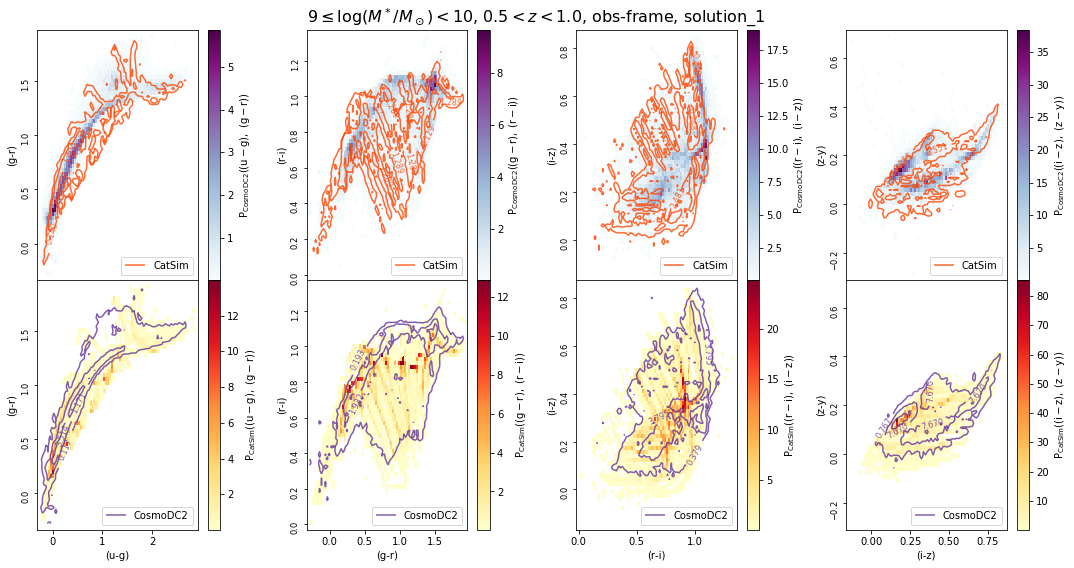

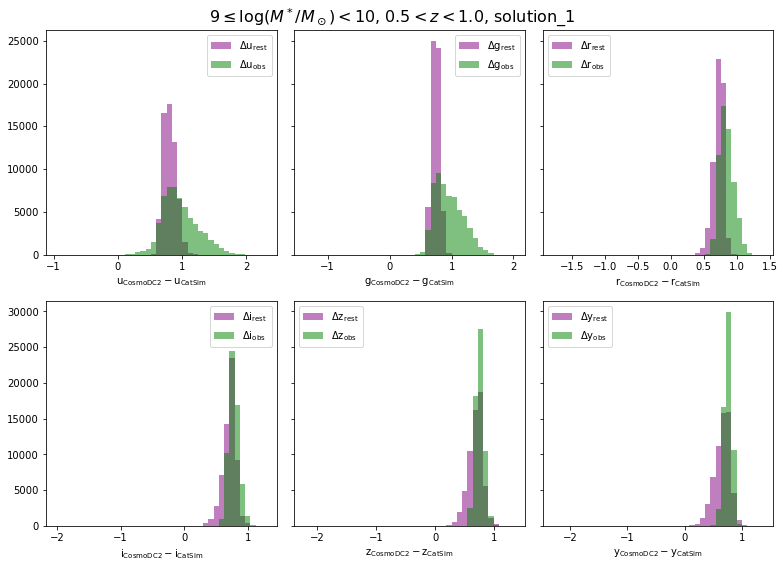

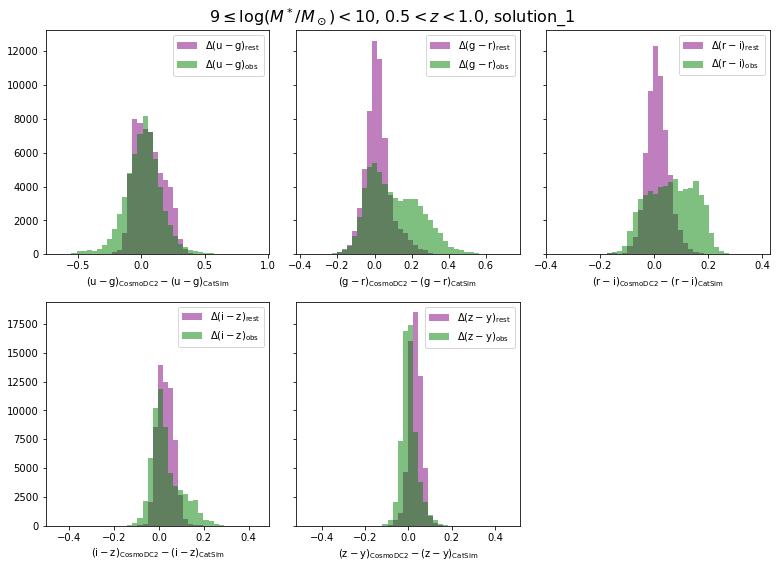

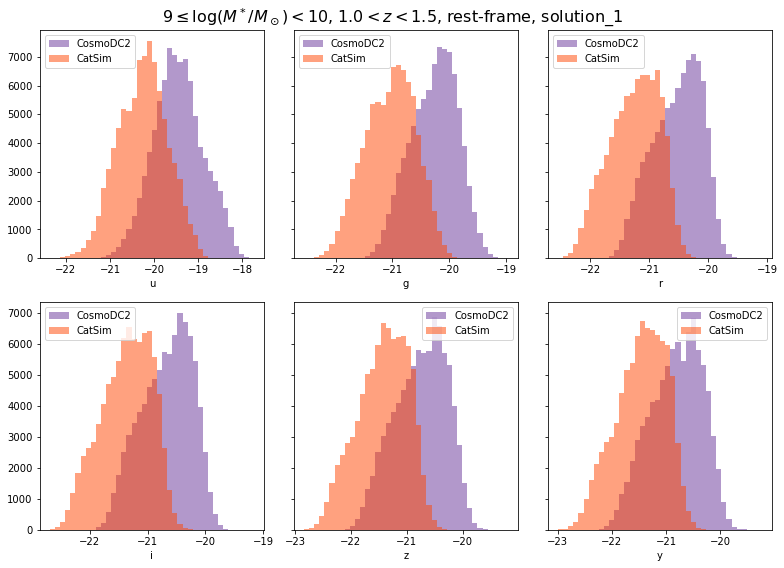

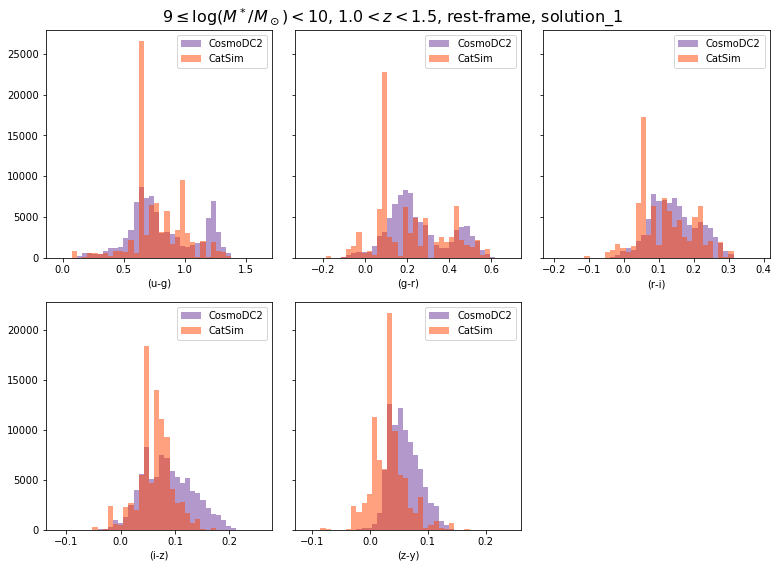

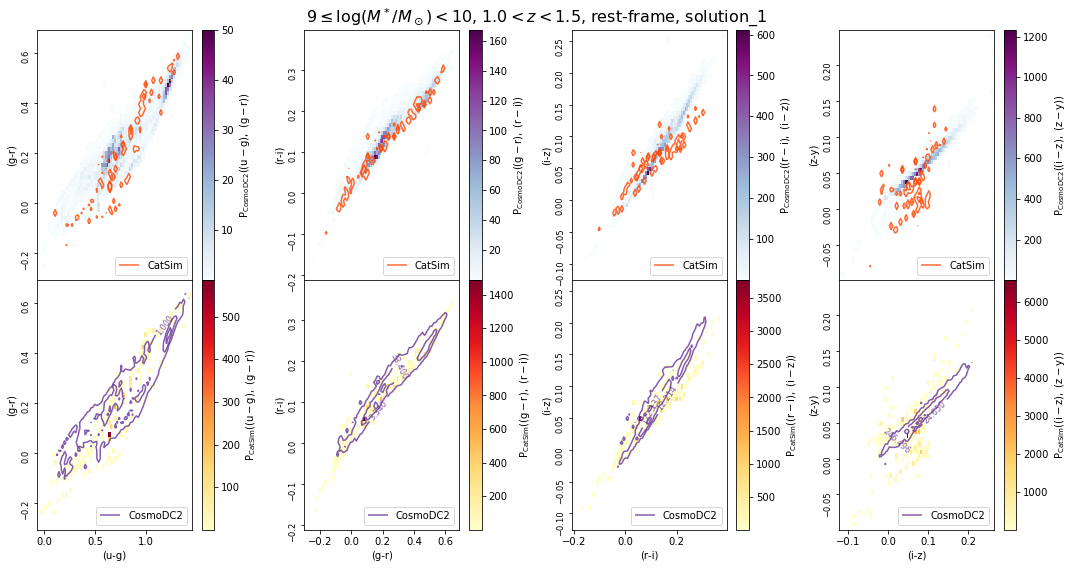

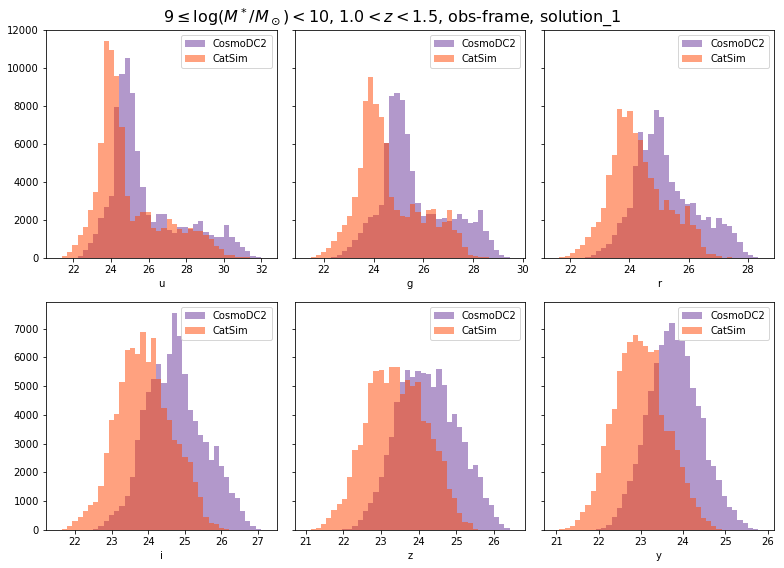

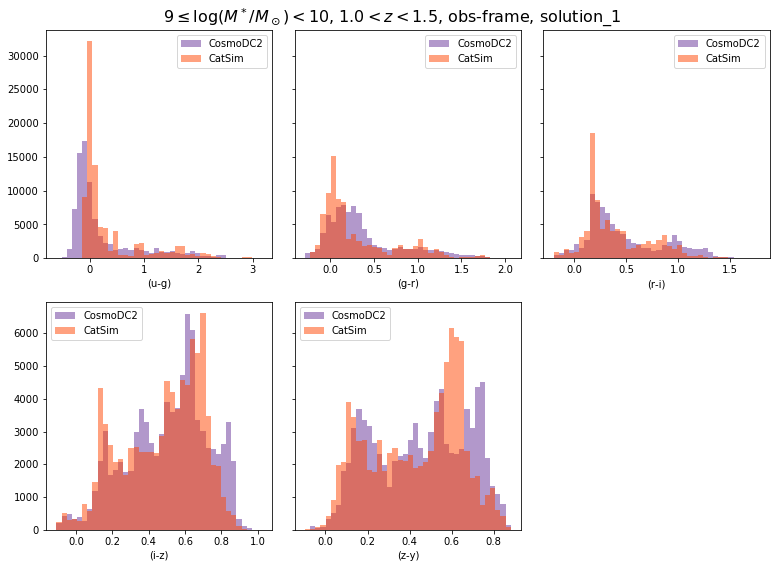

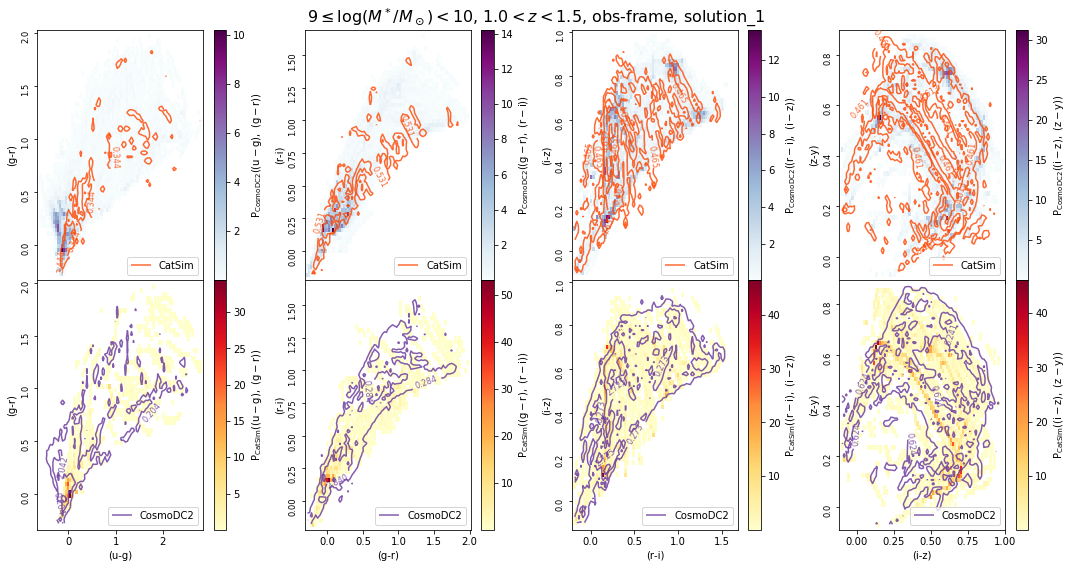

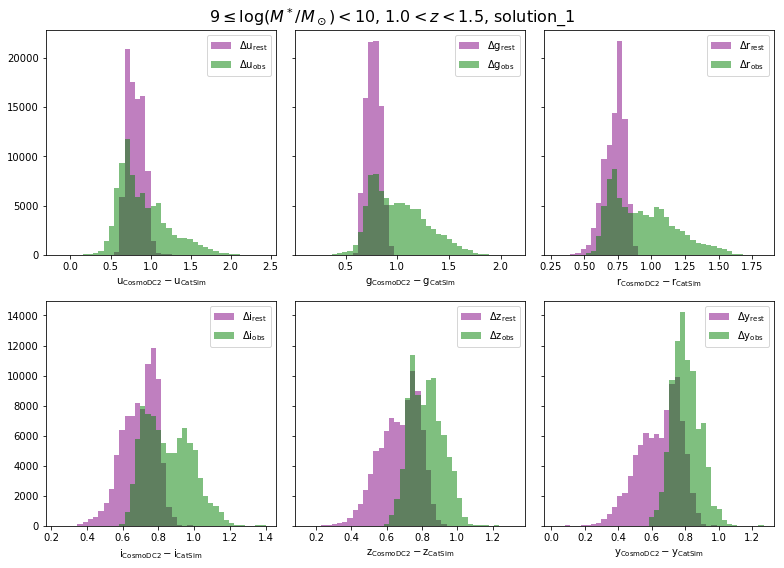

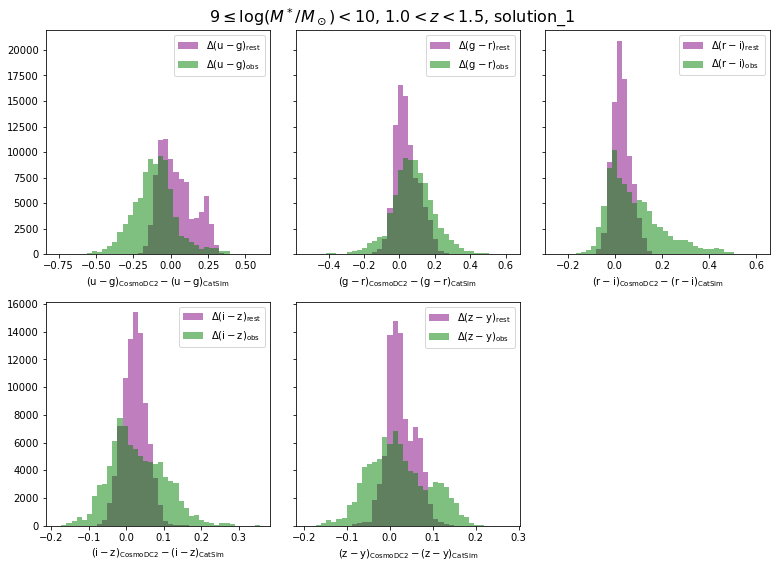

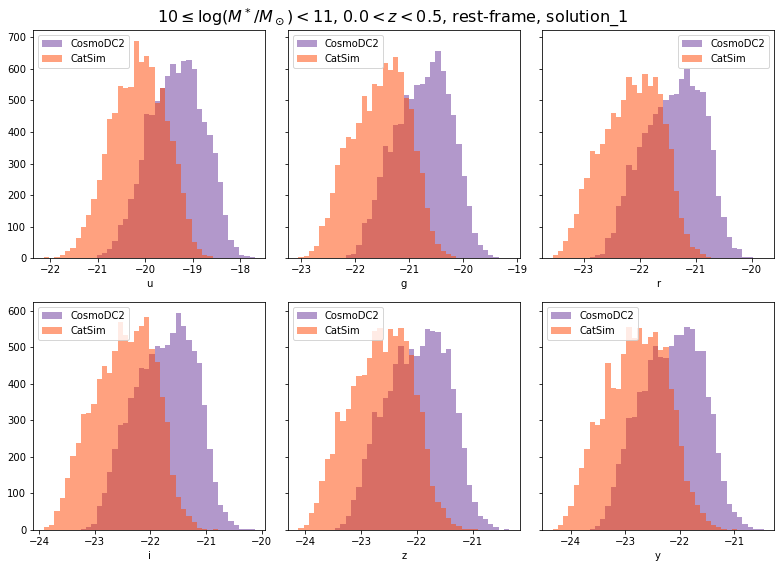

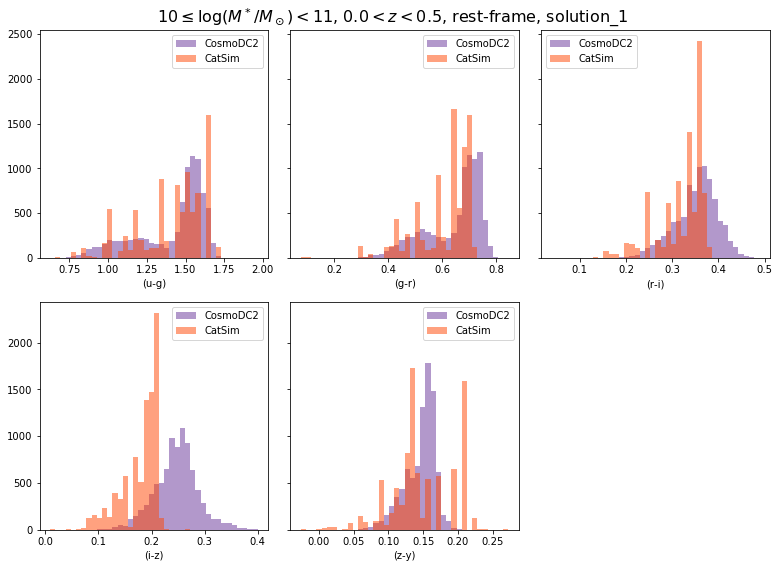

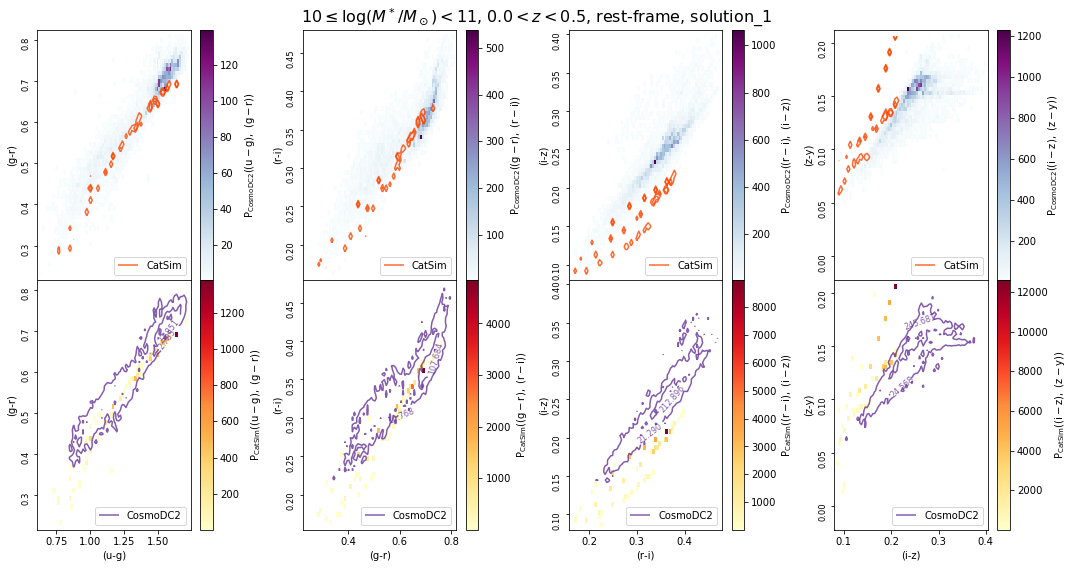

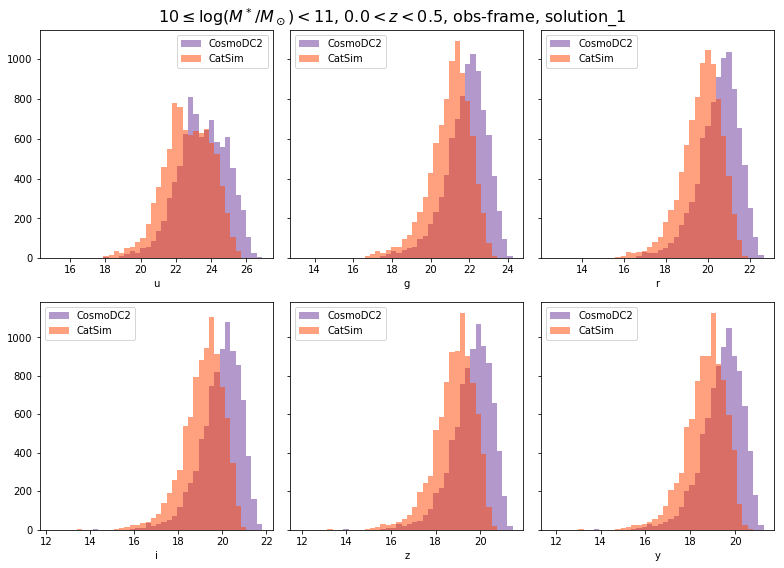

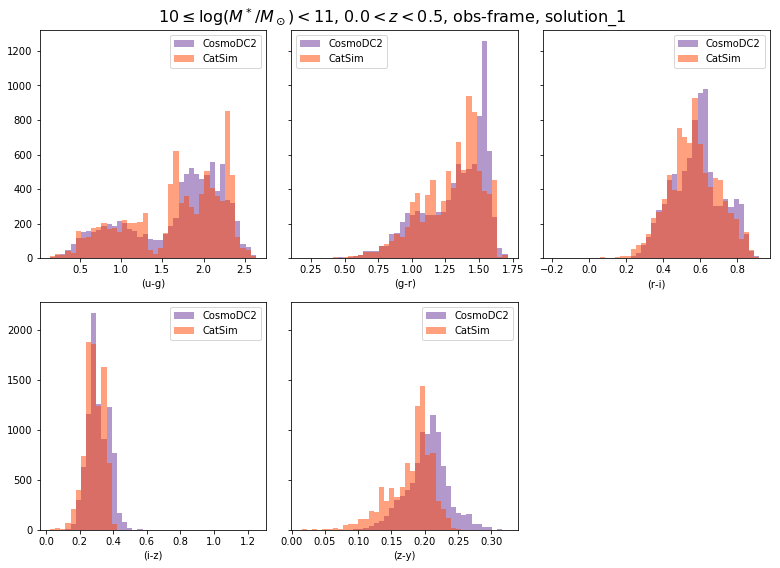

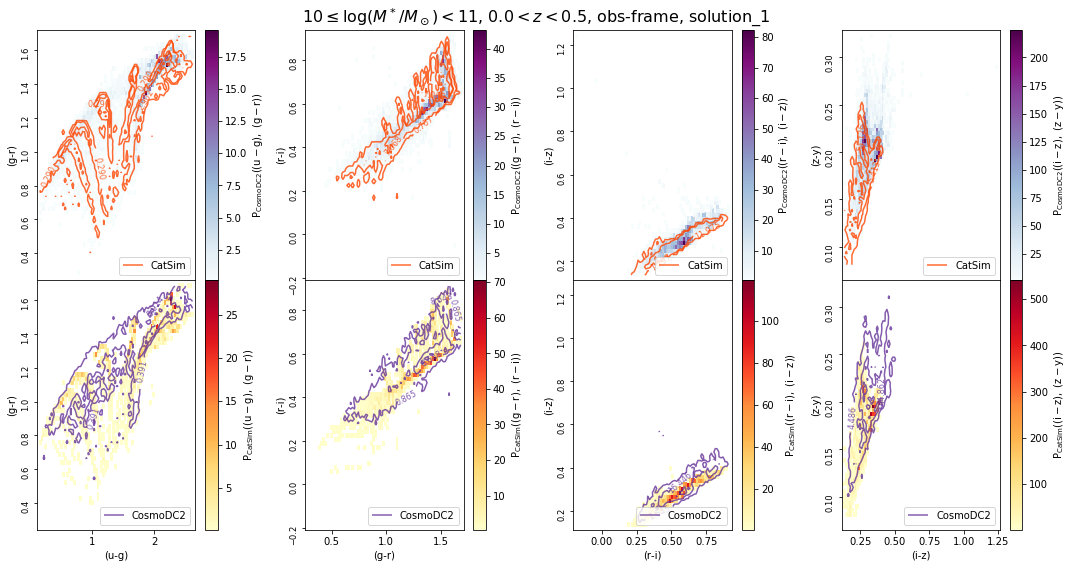

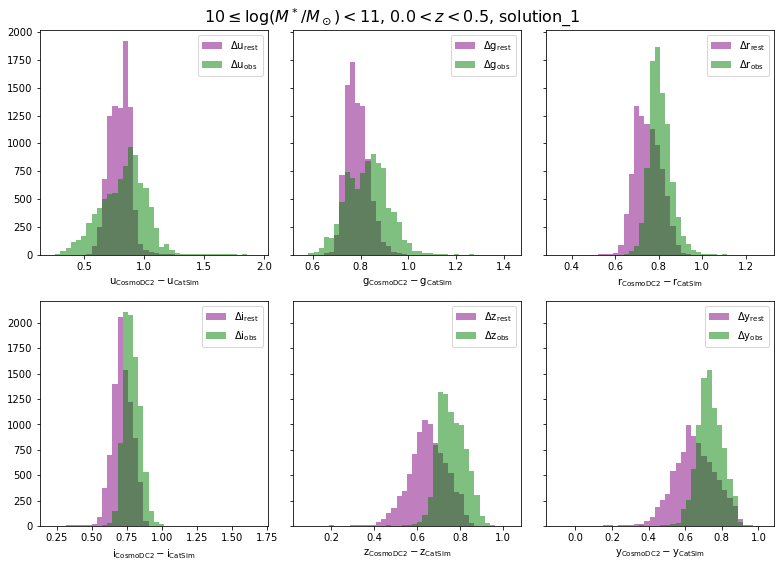

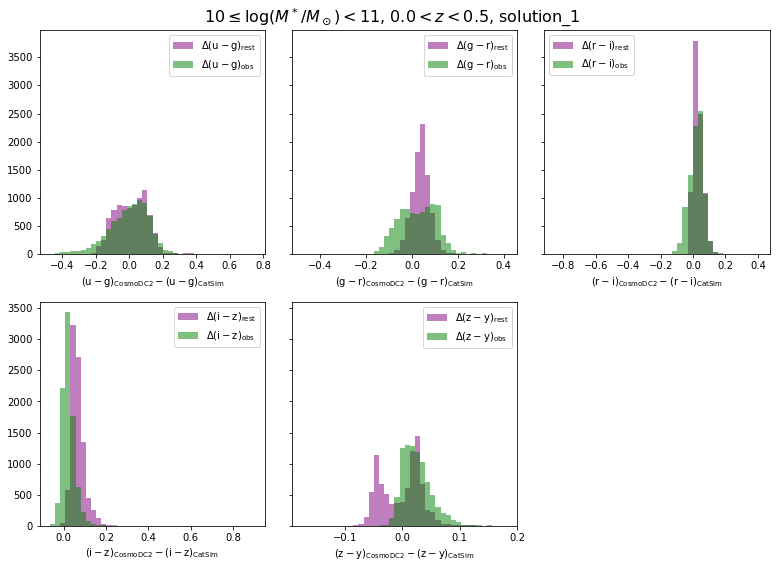

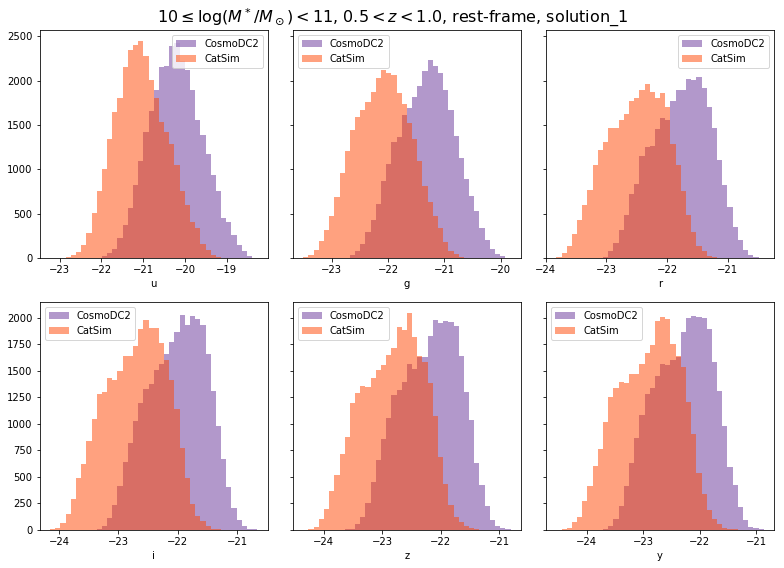

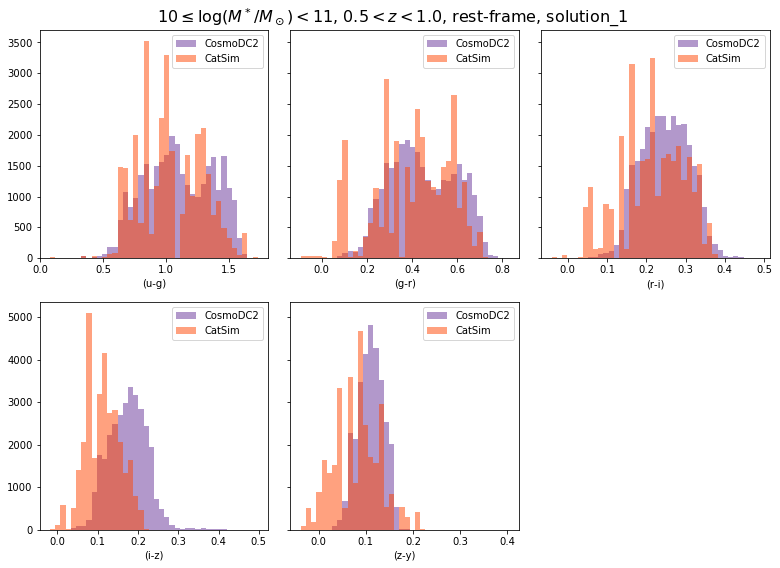

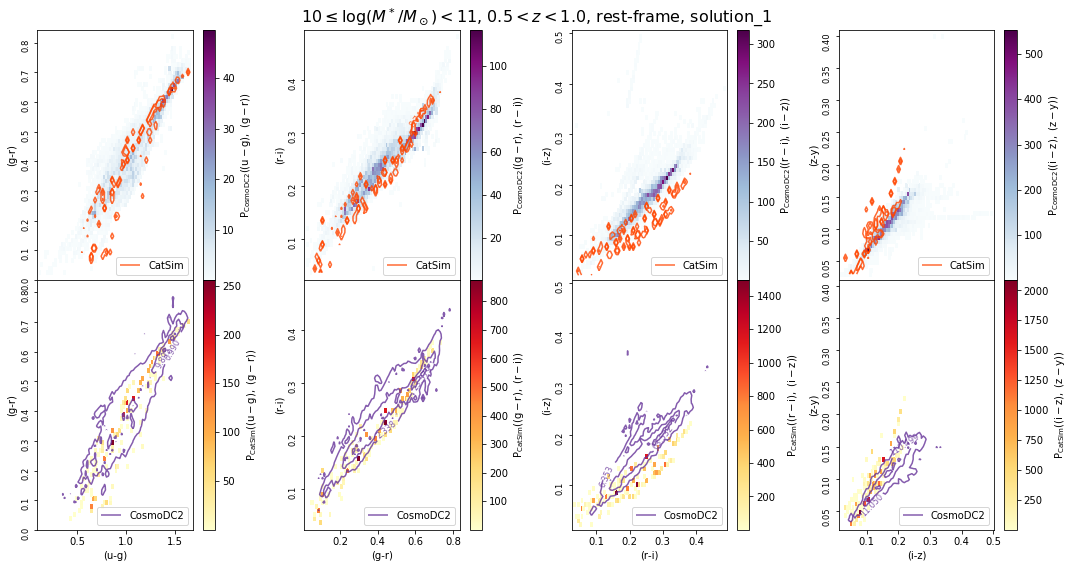

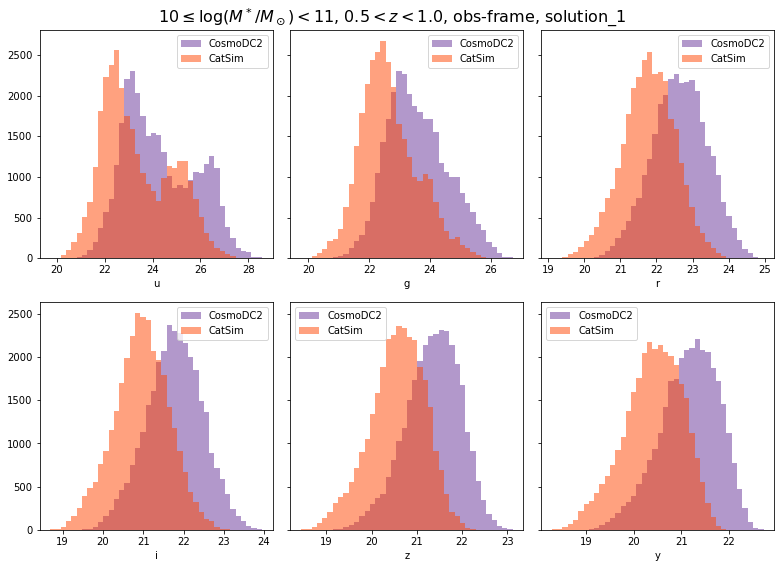

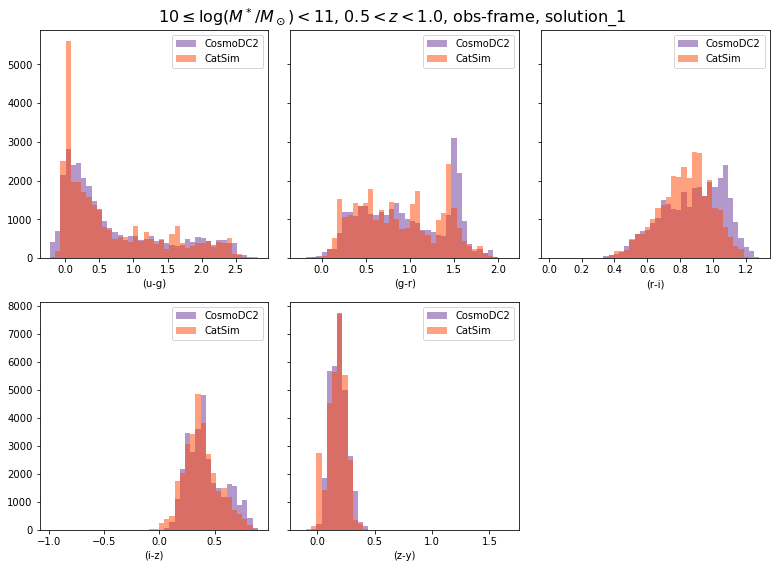

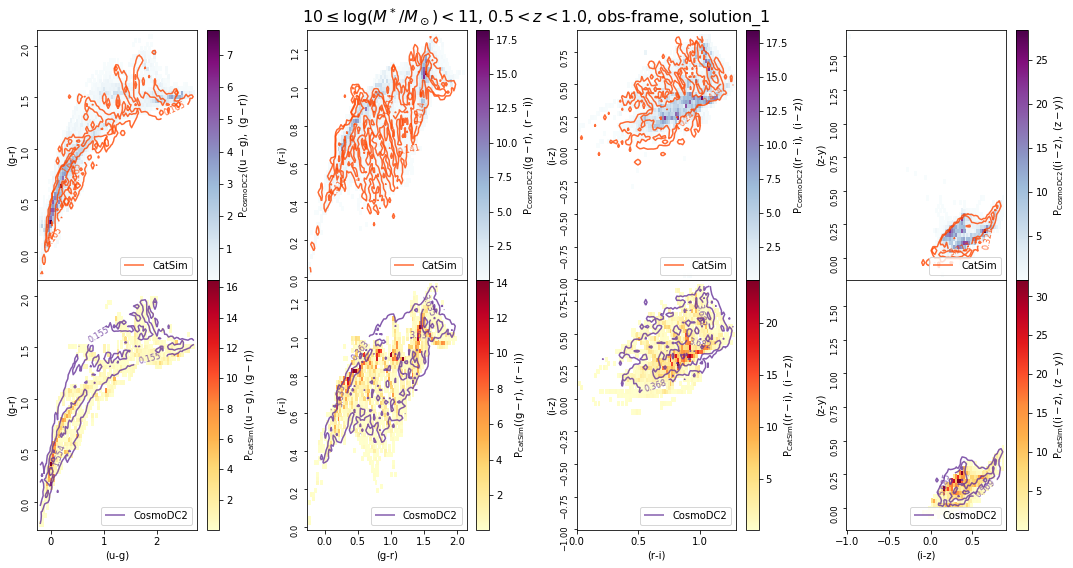

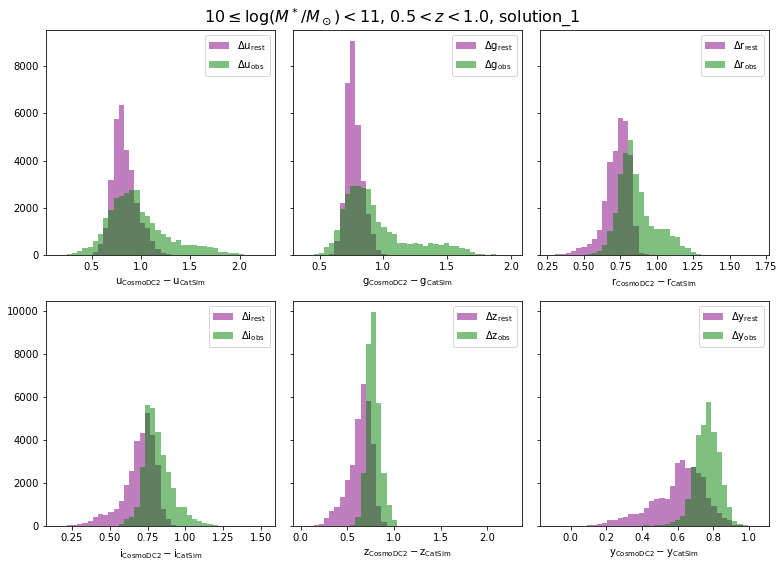

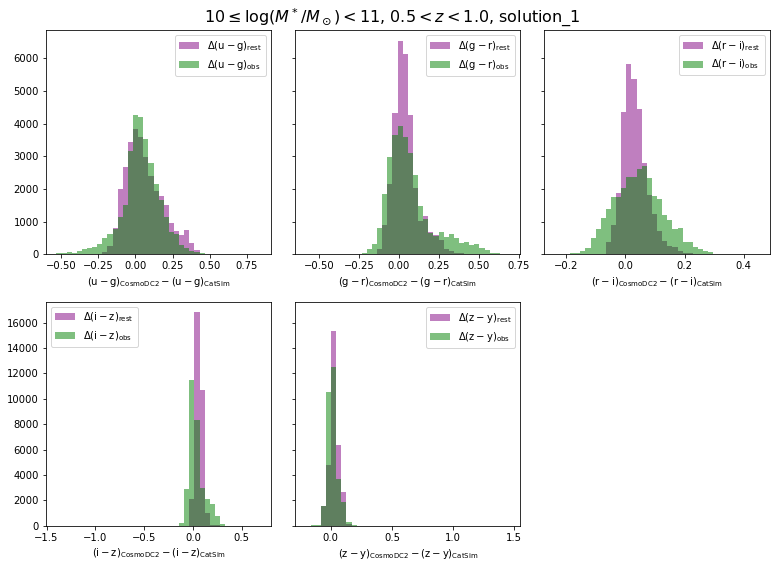

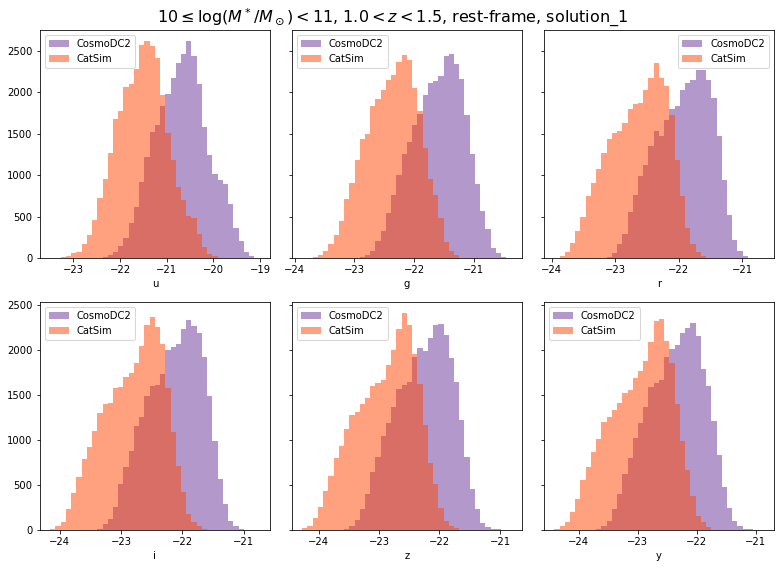

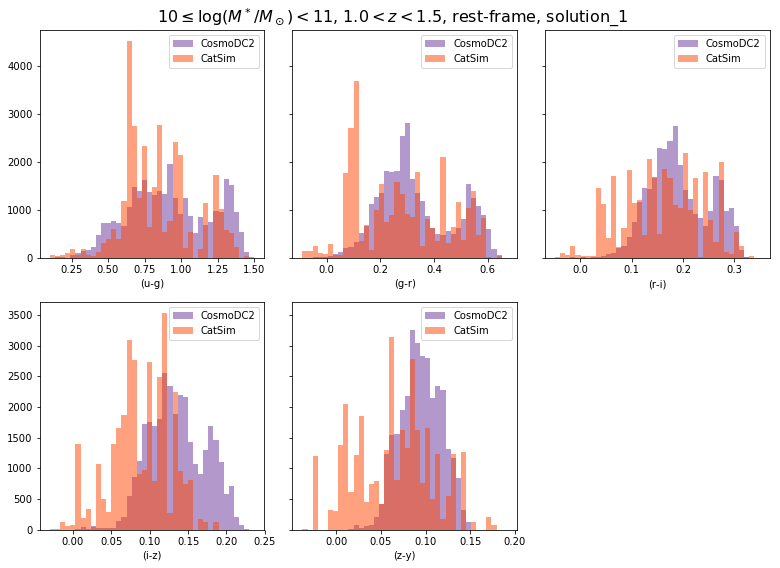

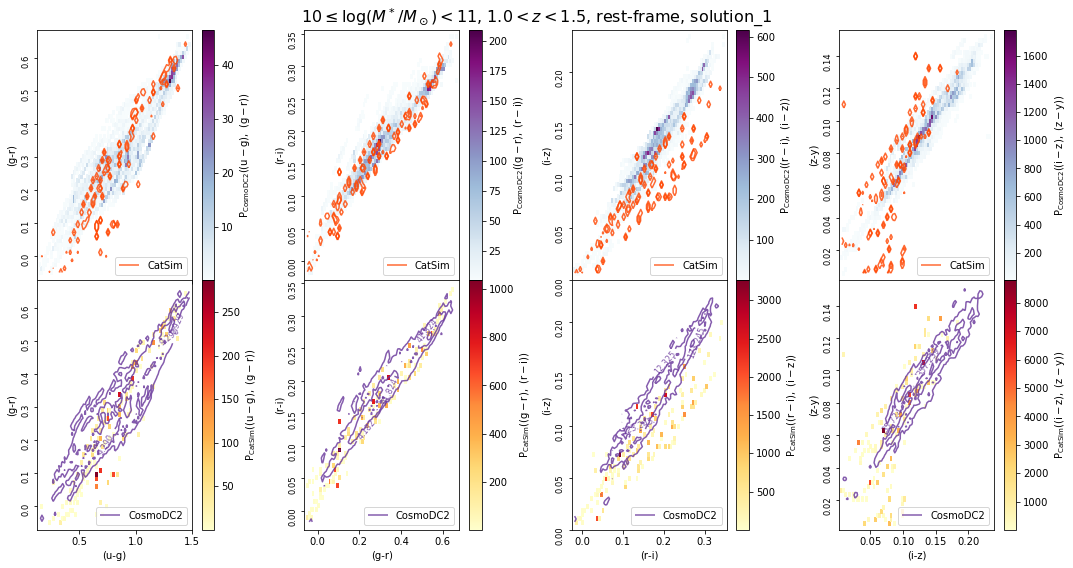

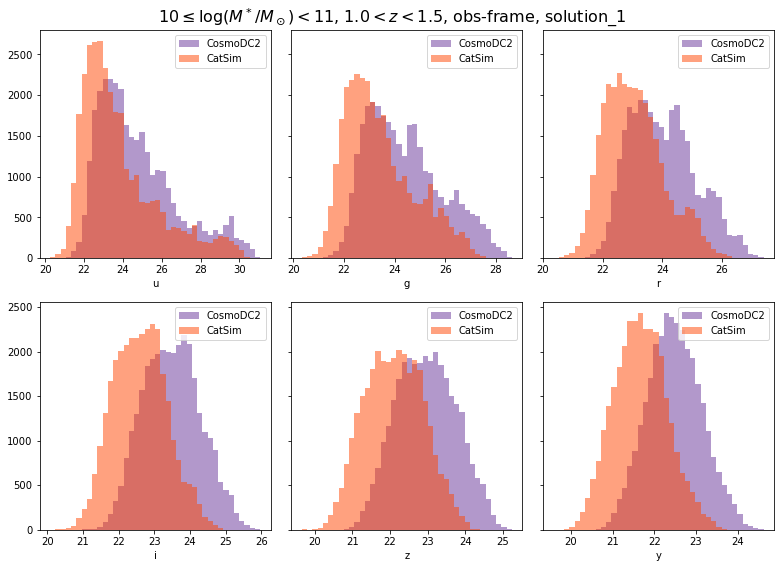

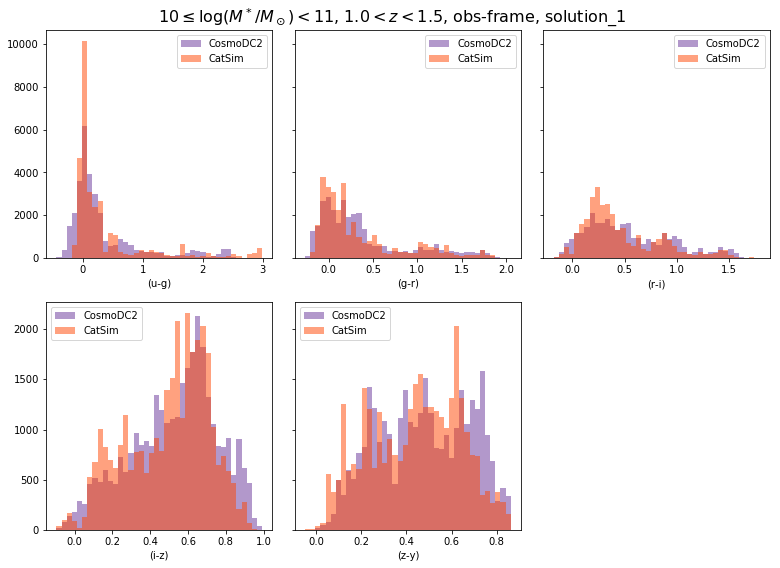

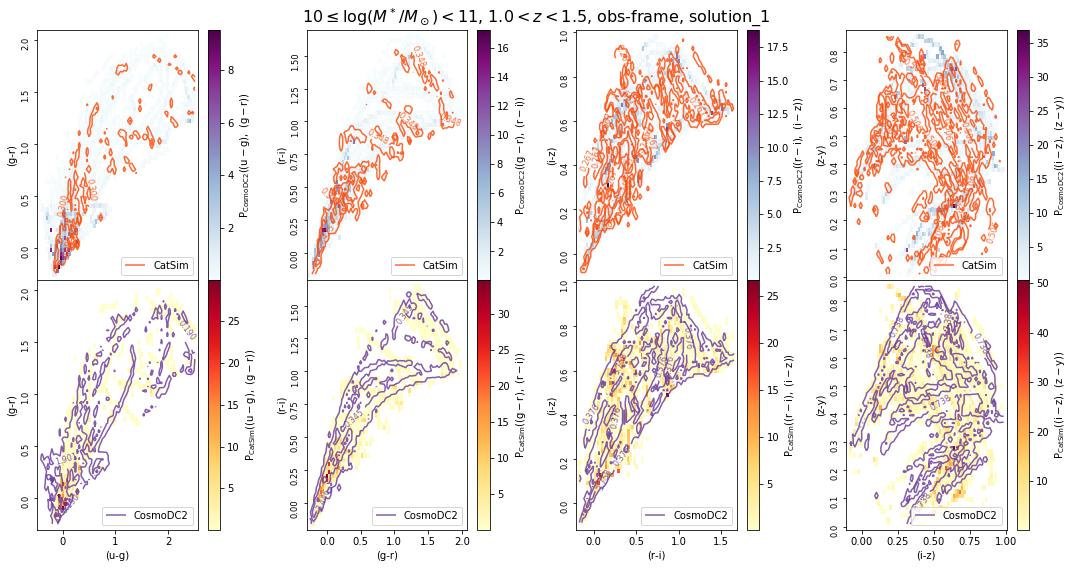

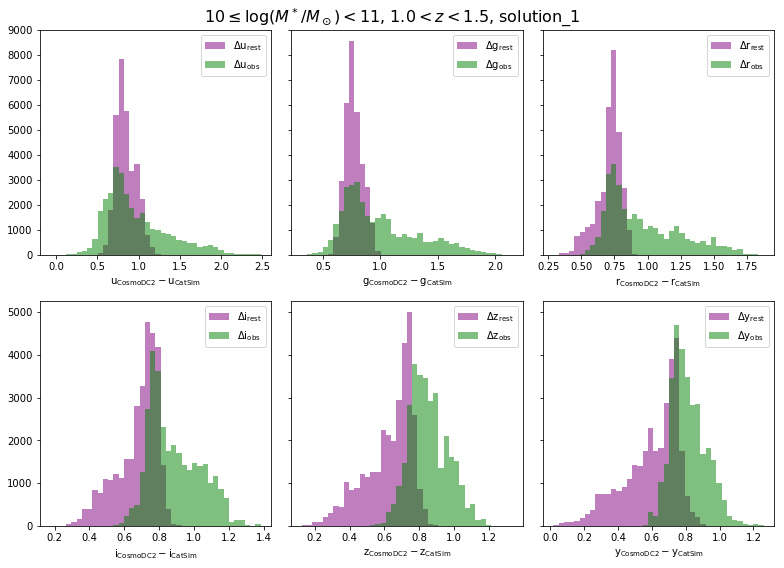

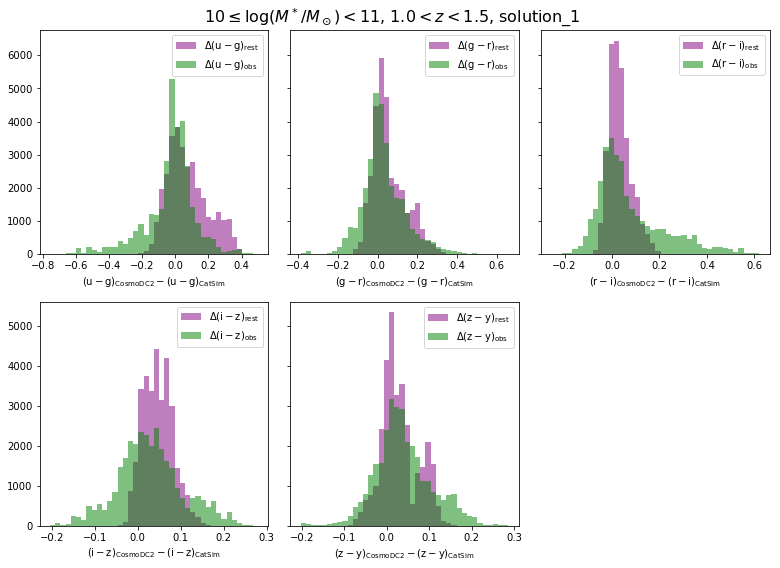

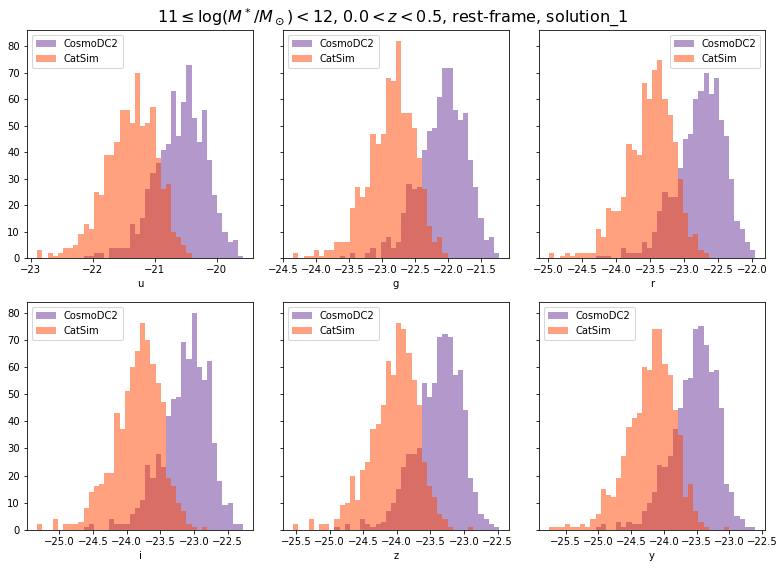

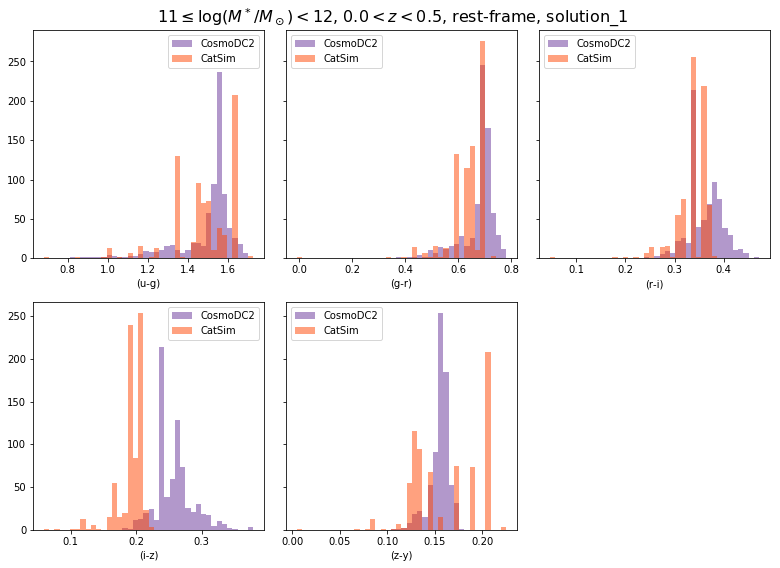

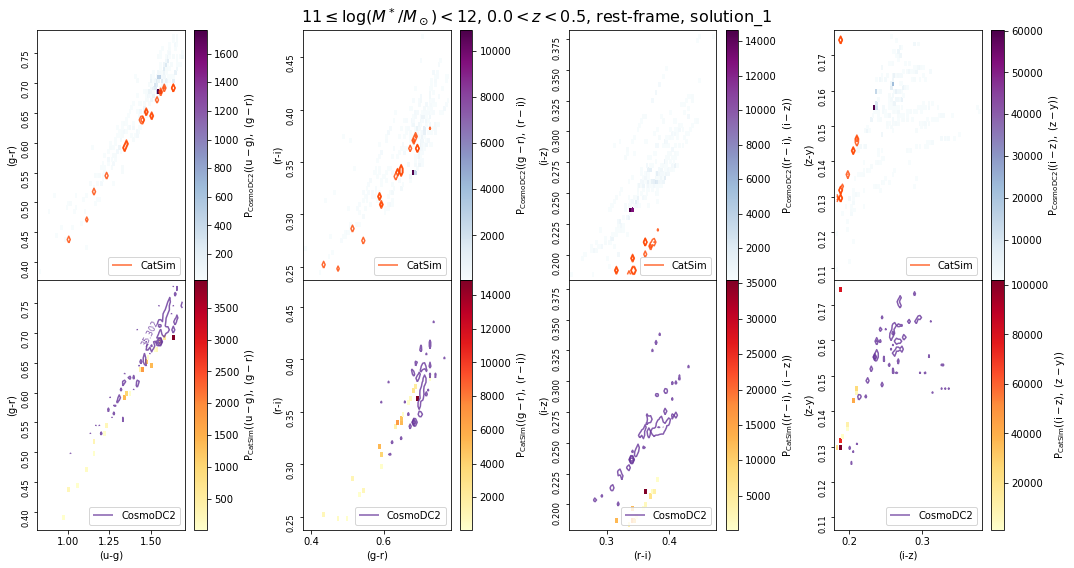

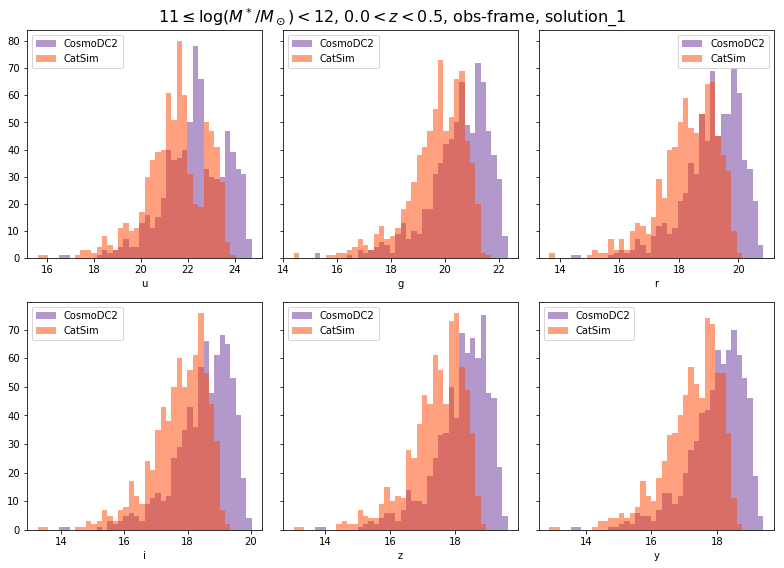

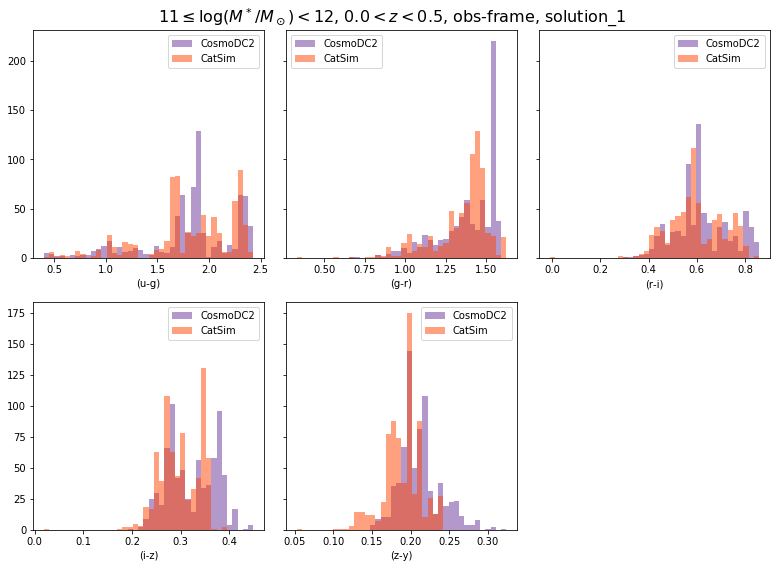

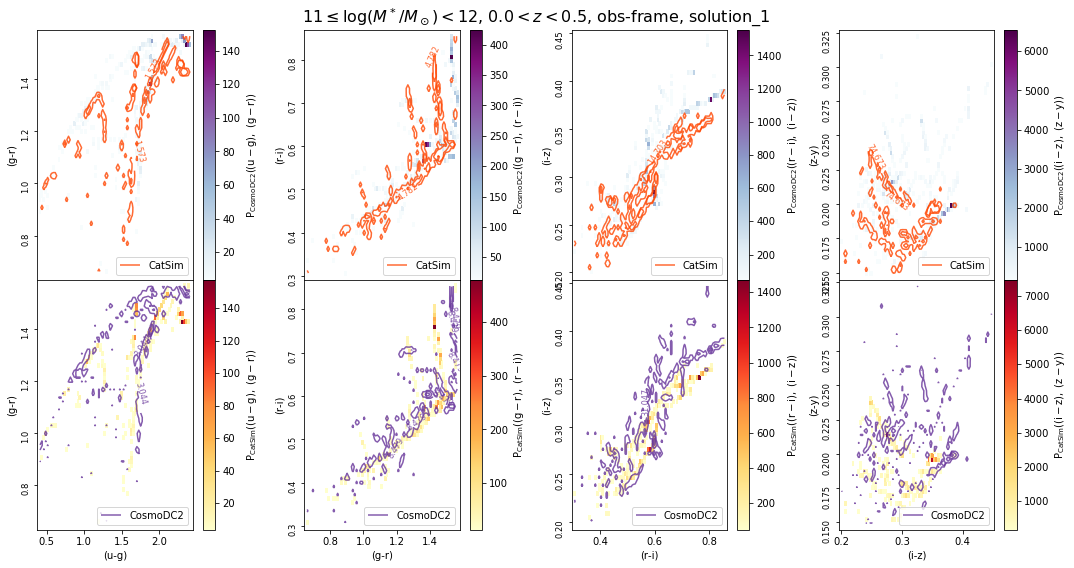

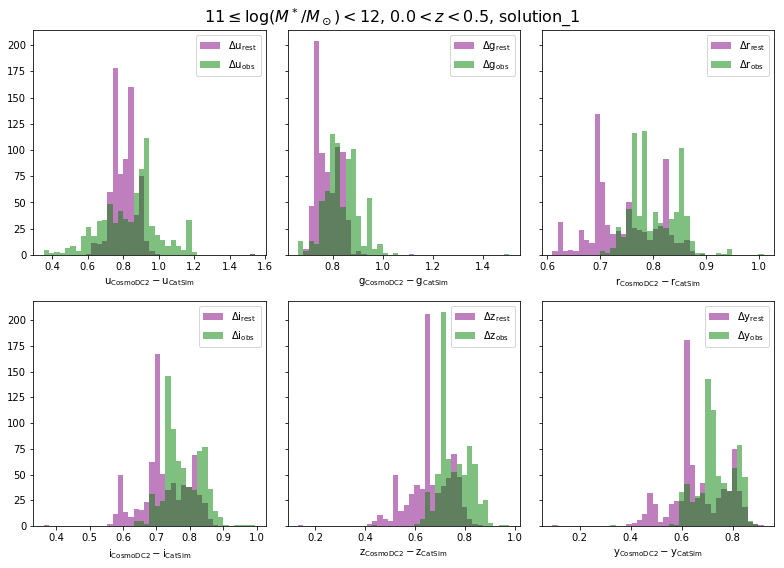

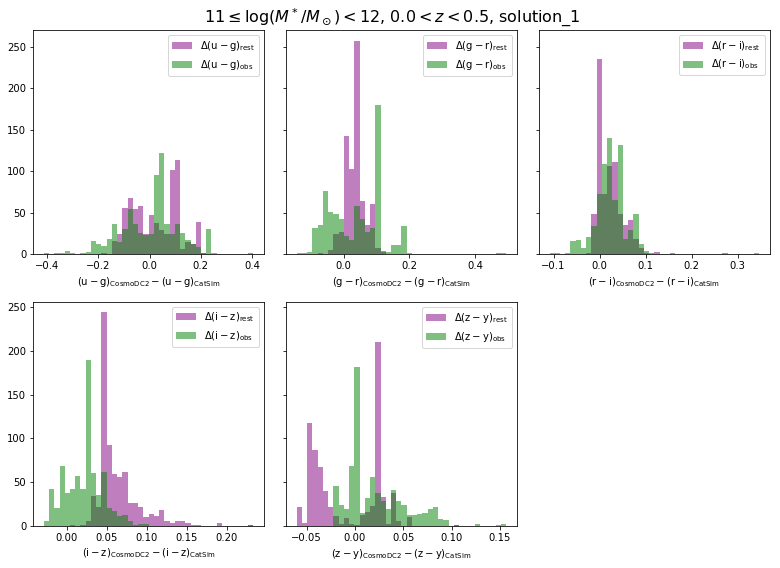

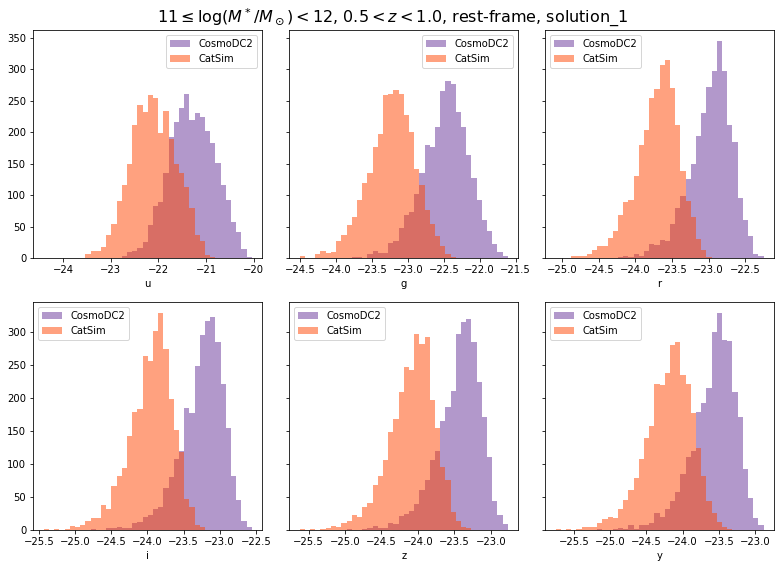

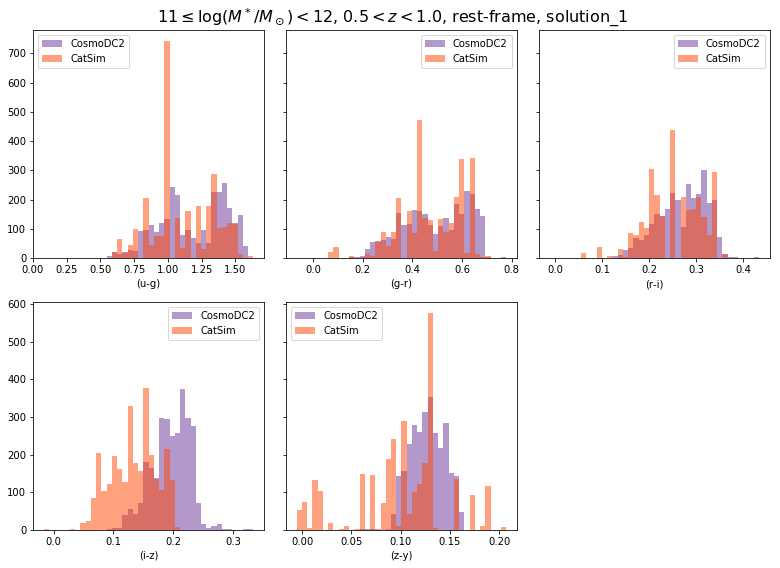

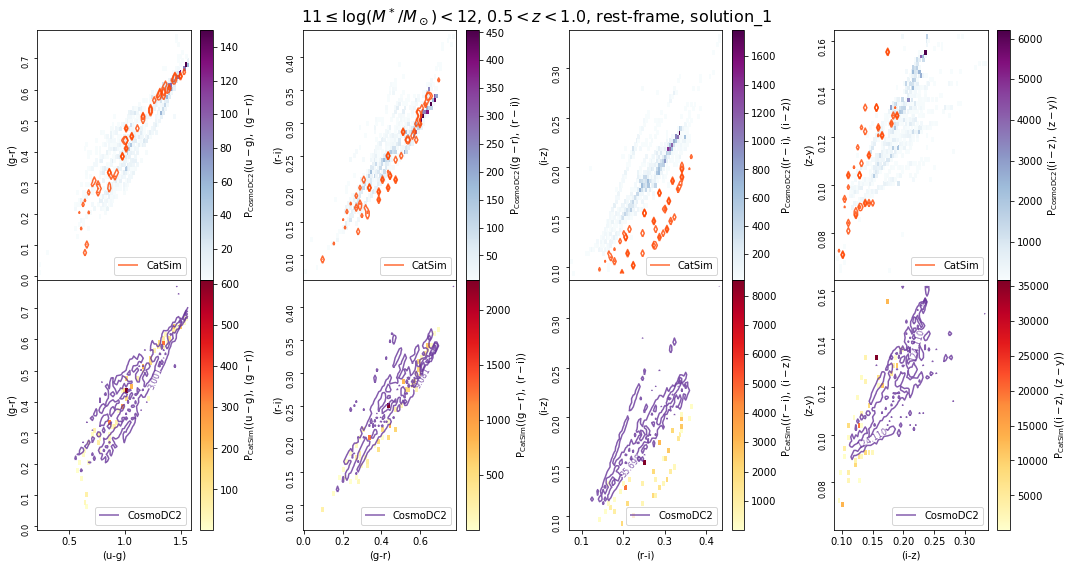

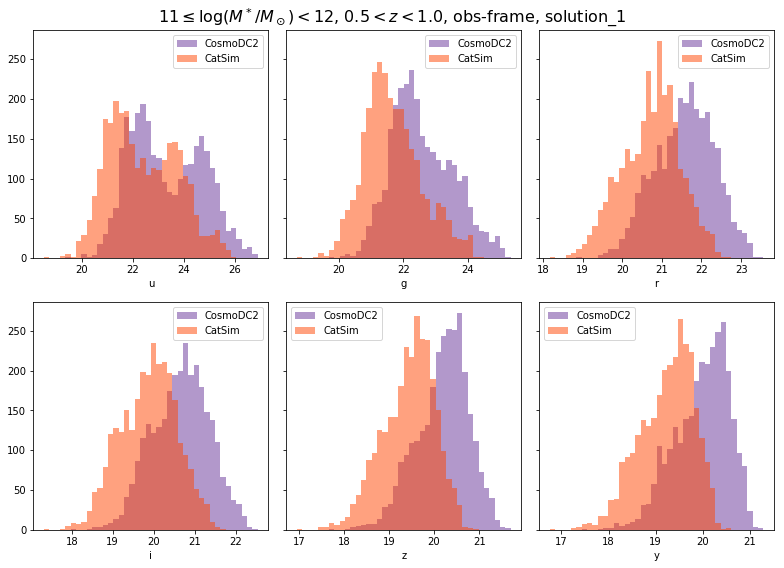

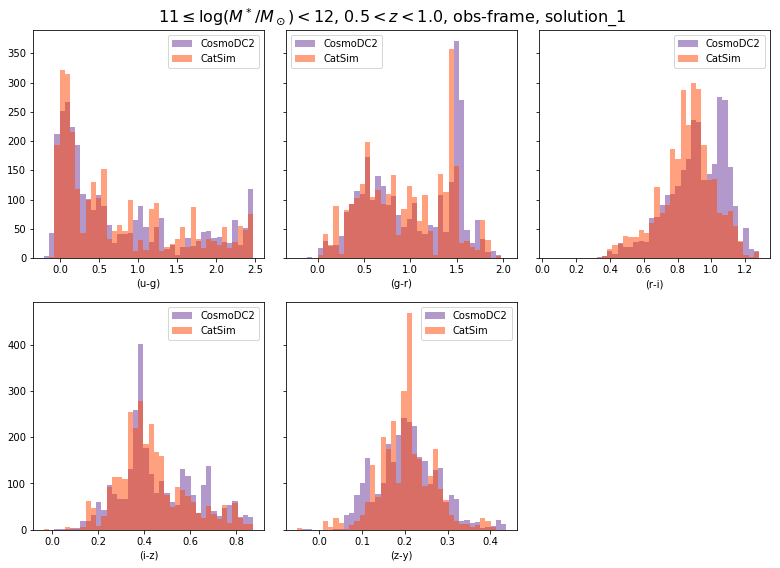

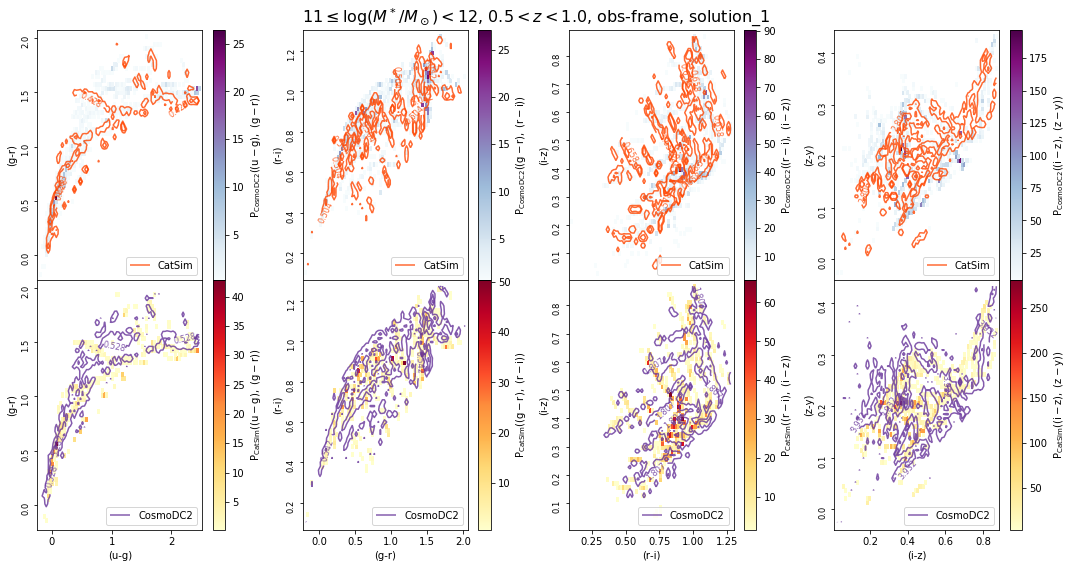

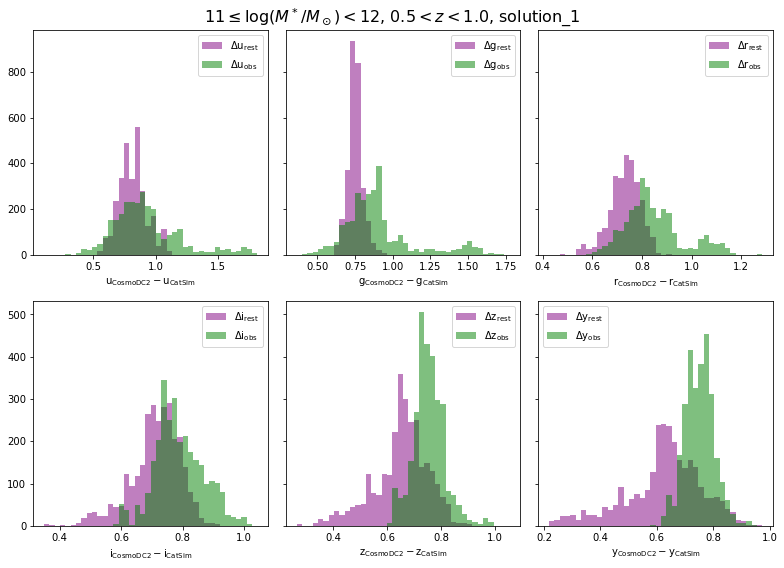

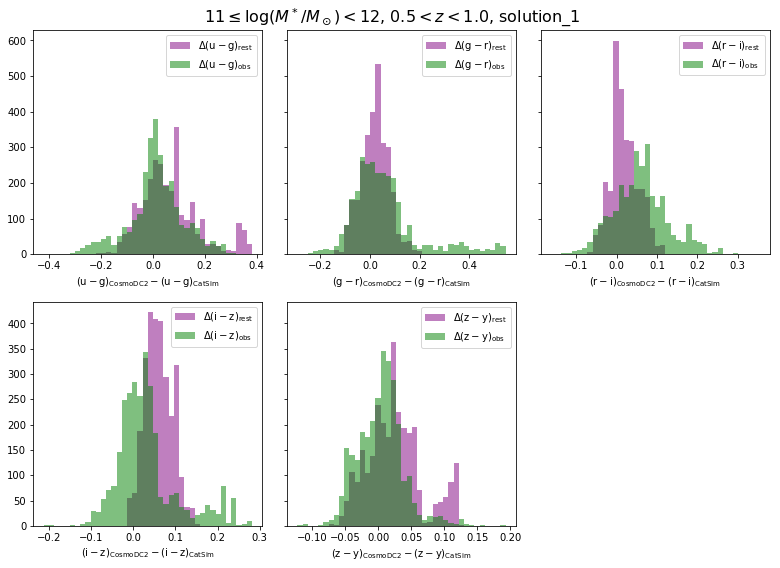

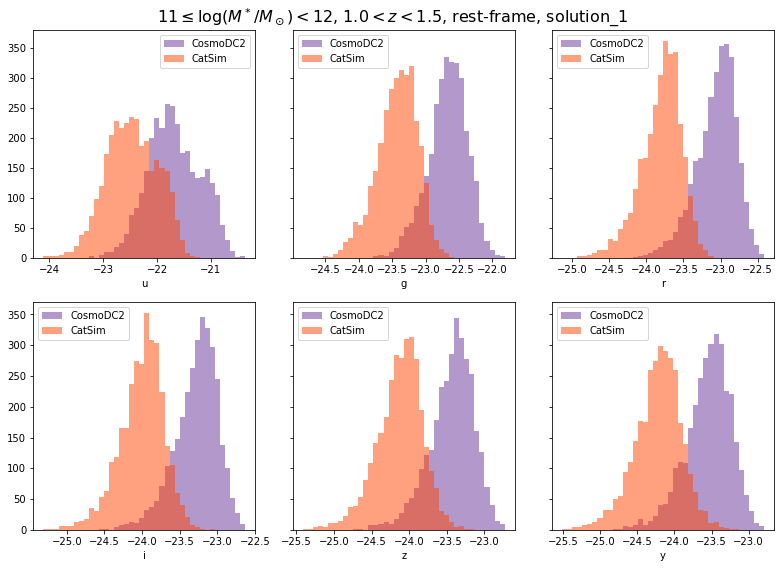

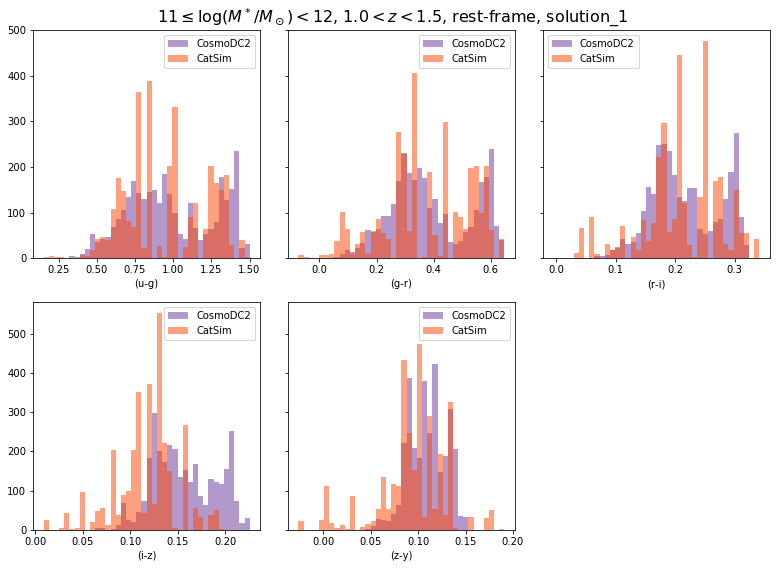

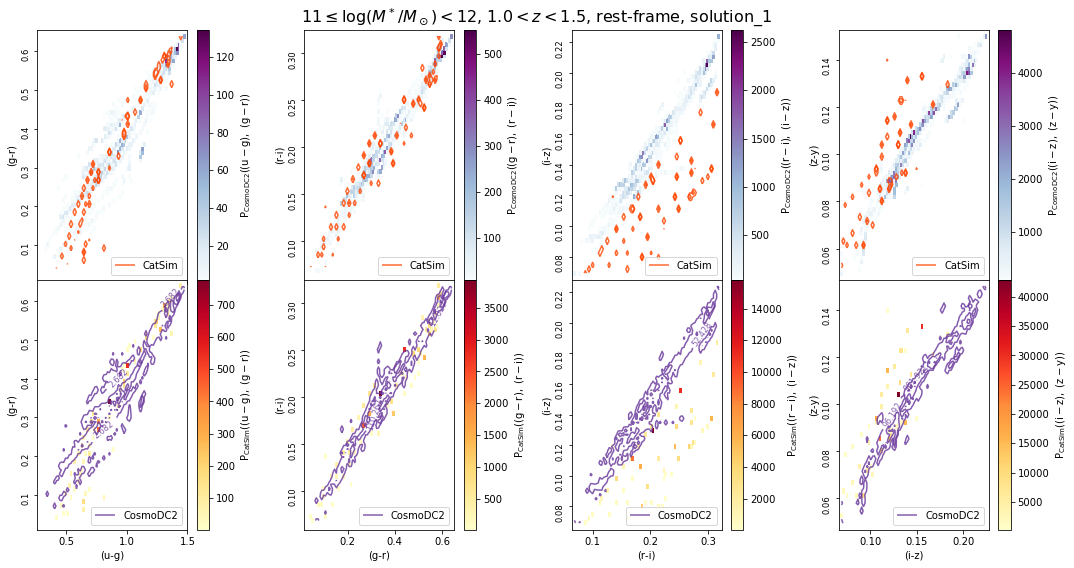

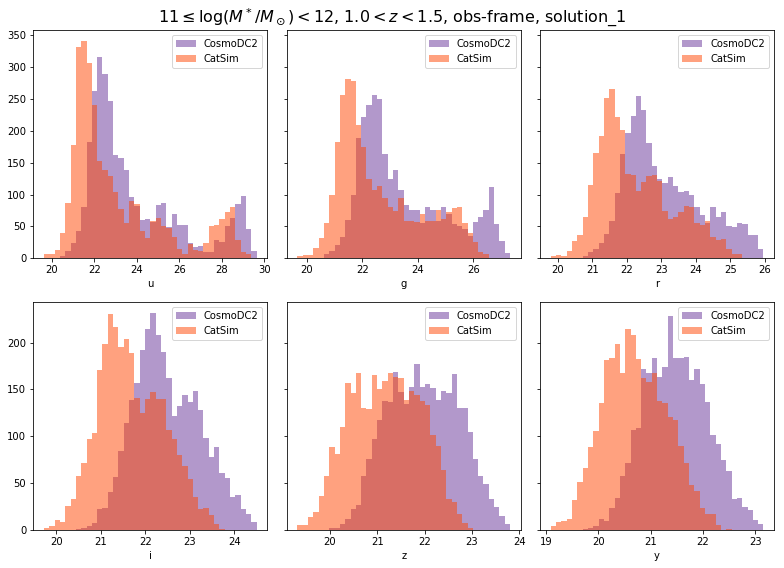

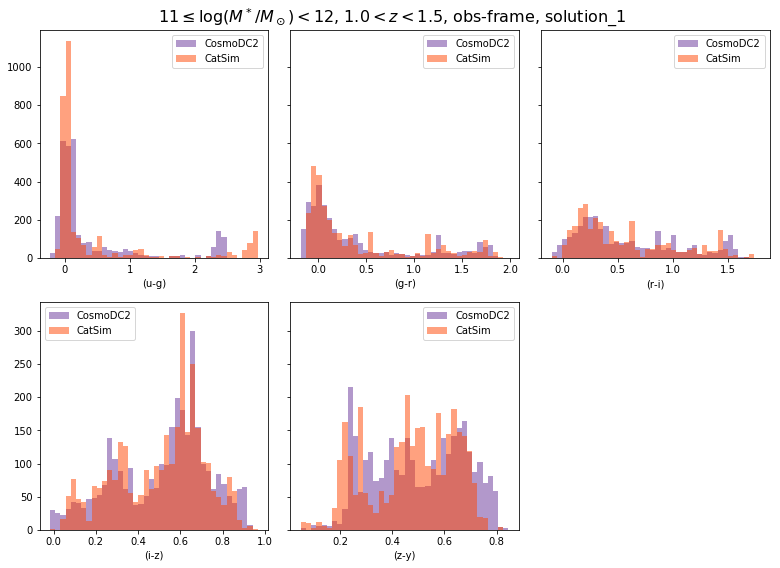

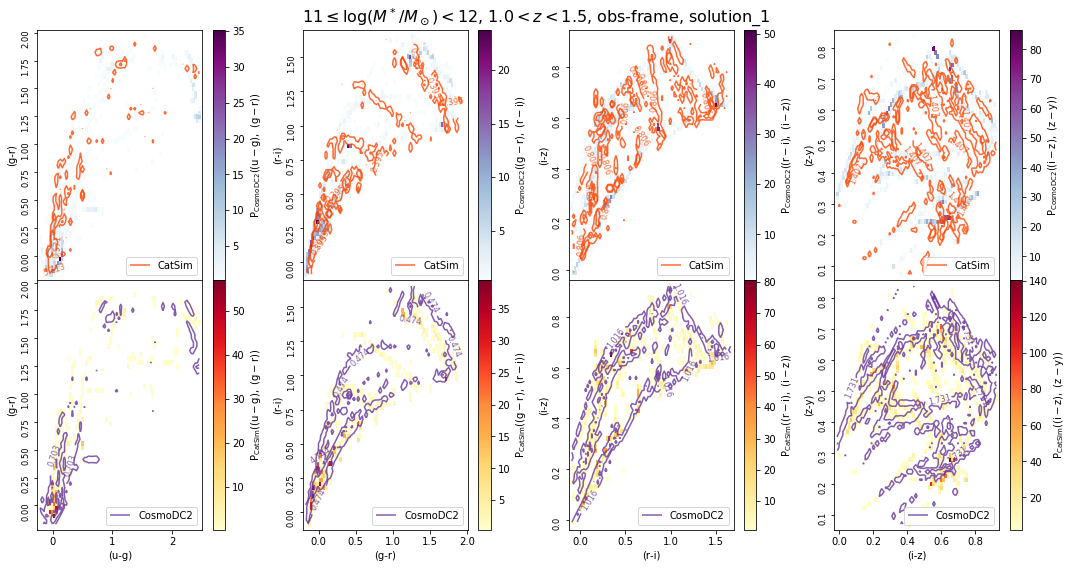

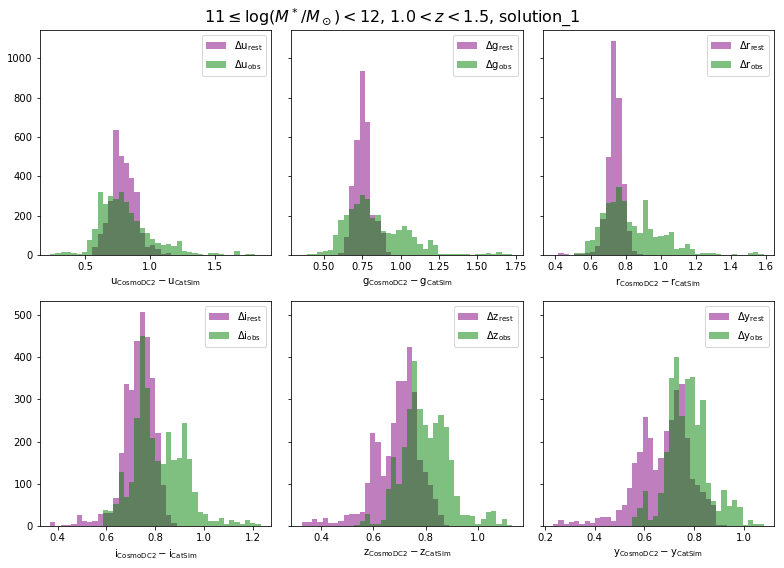

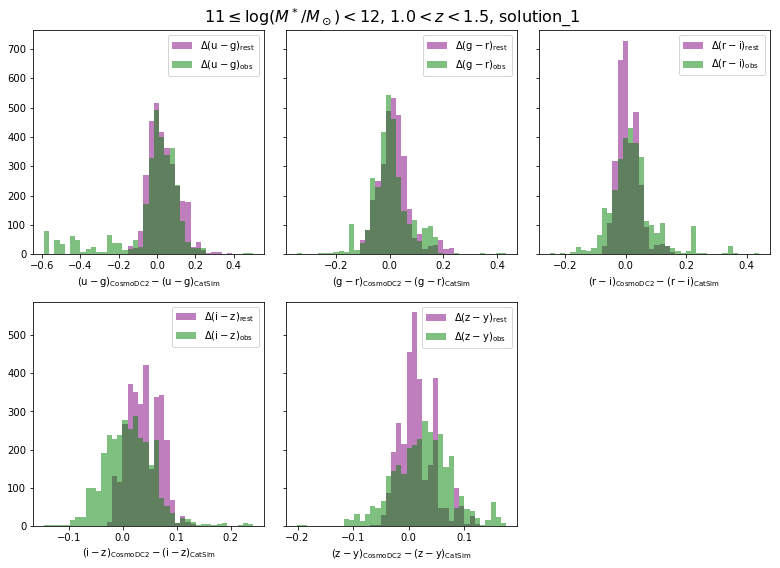

In [19]:
#make series of plots
from itertools import zip_longest
zlos = [0.0, 0.5, 1.0]
zhis = [0.5, 1.0, 1.5]
logmass = [9, 10, 11]
frame = ['rest', 'obs']
frame_colors = ['purple', 'green']
#logmass =  [10]
#zlos = [0.5]
#zhis = [1.0]
cd2_levels = [.02, .2, .6]
cs_levels = [.01, .1]
linewidths = np.asarray([.1, 1., 10])
Nbins = 40
Nxbins = 80
Nybins = 60
cd2_color = 'rebeccapurple'
cs_color = 'orangered'
cd2_map = 'BuPu'
cs_map = 'YlOrRd'
margin = 1.
alpha = 0.5
alpha2d = 0.6
alphactr = 0.8
colors = ['(u-g)', '(g-r)', '(r-i)', '(i-z)', '(z-y)']
colx = colors[0:-1]
coly = colors[1:]
for logm in logmass:
    mtitle = '$ {} \leq \log(M^*/M_\odot) < {}$'.format(str(logm), str(logm + 1))
    mfig = 'logM_{}'.format(str(logm))
    key = '{}'.format(str(logm))
    for zlo, zhi in zip(zlos, zhis):
        ztitle = '$ {:.1f} < z < {:.1f}$'.format(zlo, zhi)
        zfig = 'z_{:.1f}_{:.1f}'.format(zlo, zhi)
        redshifts = cosmodc2[key]['redshift']
        maskz = (redshifts > zlo) & (redshifts < zhi)
        print("Number of entries", np.count_nonzero(maskz))
        #print(np.min(redshifts[maskz]), np.max(redshifts[maskz]))
        for f in frames:
            fig_id = '{}_{}_{}_{}'.format(f, mfig, zfig, solution_id)
            title = '{}, {}, {}-frame, {}'.format(mtitle, ztitle, f, solution_id)
            mag_id = '{}/mag_{}'.format(solution_id, fig_id)
            plot_qty_dist(cosmodc2[key][f], catsim[key][f], maskz, bands, Nbins, 
                          cd2_color, cs_color, alpha, mag_id, title)
            
            color_id = '{}/color_{}'.format(solution_id, fig_id)
            plot_qty_dist(cosmodc2[key][f], catsim[key][f], maskz, colors, Nbins, 
                          cd2_color, cs_color, alpha, color_id, title)
        
            colcol_id = '{}/color_color_{}'.format(solution_id, fig_id)
            plot_qxqy_2dmap(cosmodc2[key][f], catsim[key][f], maskz, colx, coly, Nxbins, Nybins,
                            cs_levels, cd2_levels, cd2_color, cs_color, cd2_map, cs_map, 
                            alpha, colcol_id, title)
        
        #difference plots
        fig_id = '{}_{}_{}'.format(mfig, zfig, solution_id)
        title = '{}, {}, {}'.format(mtitle, ztitle, solution_id)
        dmag_id = '{}/delta_mag_{}'.format(solution_id, fig_id)
        plot_qty_diff(cosmodc2[key], catsim[key], maskz, bands, frames, Nbins, 
                      frame_colors, alpha, dmag_id, title)
        dcolor_id = '{}/delta_color_{}'.format(solution_id, fig_id)
        plot_qty_diff(cosmodc2[key], catsim[key], maskz, colors, frames, Nbins, 
                      frame_colors, alpha, dcolor_id, title)     